# У России три пути: 1 - Сомнительно, но ок, 2 - Не советую, 3 - и IT. Или почему я решил сменить место работы

# Часть 1:  Исследование вакансий дата аналитиков

**Цель:**

Описание полей в данных

- id - Уникальный идентификатор вакансии.
- name - Название вакансии.
- published_at - Дата публикации.
- url - Ссылка на вакансию.
- type - Статус вакансии на момент получения данных от api и передачи
их в базу.
- employer - Работодатель.
- area - Регион места работы.
- experience - Требуемый опыт работы.
- professional_role - Код и расшифровка, характериные для специализации вакансии
- key_skills - Ключевые навыки, в том числе найденные при анализе
полного текста вакансии. Поле генерируется после получения
информации от api.
- schedule - График работы.
- employment - Тип занятости.
- description - Описание вакансии.
- salary_from - Нижняя граница предлагаемой заработной платы.
- salary_to - Верхняя граница предлагаемой заработной платы.
- experience_cat - Категория опыта, где 0 - без опыта, а 3 - от 6 лет
- predicted_salary - предсказанная зарплата с помощью методов машинного обучения
- grade - предсказнный грейд с помощью методов машинного обучения


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud, STOPWORDS

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('figure', figsize=(15, 6))
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

#Загрузка и предобработка данных

Данные были взяты из базы данных, созданной мною на ресурсе supabase. В течение года по API hh.ru скачивались вакансии дата аналитиков, продуктовых аналитиков и bi-аналитиков.
При скачивании данные предобрабатывались и записывались в базу.
На момент анализа - 15.07.2025 в базе присусутствует 9083 вакансии.

In [ ]:
# загружаем эксел файл и называем его da
da = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vacancies_hh_2025_07_15.csv')

In [ ]:
# делаем поверхностный обзор
da.head()

id                                       vacancy_name  \
0  79889558  Аналитик данных в группу управления метаданным...   
1  85216340                                 Бизнес-аналитик BI   
2  86004285               Аналитик (г. Москва, ш. Энтузиастов)   
3  86617759                     Продуктовый аналитик (app/web)   
4  86906212                          Лид продуктовой аналитики   

           schedule          experience          city            employer  \
0       Полный день  От 1 года до 3 лет        Москва                 МТС   
1       Полный день       От 3 до 6 лет  Екатеринбург              Т-Банк   
2       Полный день       От 3 до 6 лет        Москва       Байкал-Сервис   
3  Удаленная работа       От 3 до 6 лет        Москва  Спортивные лотереи   
4       Полный день       От 3 до 6 лет        Москва              Т-Банк   

   salary_from  salary_to      type                             url  \
0          NaN        NaN  Открытая  https://hh.ru/vacancy/79889558   
1          NaN        NaN  Открытая  https://hh.ru/vacancy/85216340   
2          NaN        NaN  Открытая  https://hh.ru/vacancy/86004285   
3          NaN        NaN  Открытая  https://hh.ru/vacancy/86617759   
4          NaN        NaN  Открытая  https://hh.ru/vacancy/86906212   

                                          key_skills  \
0  Data Catalog, DMBOK DAMA, Business Glossary, D...   
1  Tableau, SQL, Python, SAP Business Objects, Ан...   
2  Аналитика продаж, Подготовка отчетов, Анализ д...   
3   Google Analytics, Яндекс.Метрика, A/B тесты, SQL   
4                                                NaN   

                                 professional_role  \
0               [{'id': '10', 'name': 'Аналитик'}]   
1               [{'id': '10', 'name': 'Аналитик'}]   
2               [{'id': '10', 'name': 'Аналитик'}]   
3  [{'id': '164', 'name': 'Продуктовый аналитик'}]   
4  [{'id': '164', 'name': 'Продуктовый аналитик'}]   

                                         description            published_at  \
0  Мы приглашаем в нашу команду аналитиков, котор...  2024-12-16 11:04:49+00   
1  Т-Банк — data-driven-компания: при принятии ре...  2025-01-23 10:52:22+00   
2  Приглашаем на работу Аналитика в Отдел Аналити...  2024-12-04 12:09:33+00   
3  Наша задача — развитие лотерейной культуры в Р...  2024-10-08 14:38:44+00   
4  Мы — продуктовая команда Т‑Банк, и наши продук...  2025-02-03 07:20:39+00   

   experience_cat  predicted_salary    grade  
0               1         88700.000  Junior+  
1               2        156200.000   Senior  
2               2        136400.000   Middle  
3               2        152700.000   Senior  
4               2        258200.000   Senior

In [ ]:
# Смотрим общую информацию по датасету data analyst
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 9083 non-null   int64  
 1   vacancy_name       9083 non-null   object 
 2   schedule           9083 non-null   object 
 3   experience         9083 non-null   object 
 4   city               9083 non-null   object 
 5   employer           9083 non-null   object 
 6   salary_from        1968 non-null   float64
 7   salary_to          1236 non-null   float64
 8   type               9083 non-null   object 
 9   url                9083 non-null   object 
 10  key_skills         5980 non-null   object 
 11  professional_role  9080 non-null   object 
 12  description        9083 non-null   object 
 13  published_at       9083 non-null   object 
 14  experience_cat     9083 non-null   int64  
 15  predicted_salary   8764 non-null   float64
 16  grade              9083 

Колонка `published_at` имеет не формат времени, исправим это.

In [ ]:
# изменение формата
da['published_at'] = pd.to_datetime(da['published_at'], utc=True)
da['published_at'] = da['published_at'].dt.tz_convert('Europe/Moscow')

In [ ]:
da.head()

id                                       vacancy_name  \
0  79889558  Аналитик данных в группу управления метаданным...   
1  85216340                                 Бизнес-аналитик BI   
2  86004285               Аналитик (г. Москва, ш. Энтузиастов)   
3  86617759                     Продуктовый аналитик (app/web)   
4  86906212                          Лид продуктовой аналитики   

           schedule          experience          city            employer  \
0       Полный день  От 1 года до 3 лет        Москва                 МТС   
1       Полный день       От 3 до 6 лет  Екатеринбург              Т-Банк   
2       Полный день       От 3 до 6 лет        Москва       Байкал-Сервис   
3  Удаленная работа       От 3 до 6 лет        Москва  Спортивные лотереи   
4       Полный день       От 3 до 6 лет        Москва              Т-Банк   

   salary_from  salary_to      type                             url  \
0          NaN        NaN  Открытая  https://hh.ru/vacancy/79889558   
1          NaN        NaN  Открытая  https://hh.ru/vacancy/85216340   
2          NaN        NaN  Открытая  https://hh.ru/vacancy/86004285   
3          NaN        NaN  Открытая  https://hh.ru/vacancy/86617759   
4          NaN        NaN  Открытая  https://hh.ru/vacancy/86906212   

                                          key_skills  \
0  Data Catalog, DMBOK DAMA, Business Glossary, D...   
1  Tableau, SQL, Python, SAP Business Objects, Ан...   
2  Аналитика продаж, Подготовка отчетов, Анализ д...   
3   Google Analytics, Яндекс.Метрика, A/B тесты, SQL   
4                                                NaN   

                                 professional_role  \
0               [{'id': '10', 'name': 'Аналитик'}]   
1               [{'id': '10', 'name': 'Аналитик'}]   
2               [{'id': '10', 'name': 'Аналитик'}]   
3  [{'id': '164', 'name': 'Продуктовый аналитик'}]   
4  [{'id': '164', 'name': 'Продуктовый аналитик'}]   

                                         description  \
0  Мы приглашаем в нашу команду аналитиков, котор...   
1  Т-Банк — data-driven-компания: при принятии ре...   
2  Приглашаем на работу Аналитика в Отдел Аналити...   
3  Наша задача — развитие лотерейной культуры в Р...   
4  Мы — продуктовая команда Т‑Банк, и наши продук...   

               published_at  experience_cat  predicted_salary    grade  
0 2024-12-16 14:04:49+03:00               1         88700.000  Junior+  
1 2025-01-23 13:52:22+03:00               2        156200.000   Senior  
2 2024-12-04 15:09:33+03:00               2        136400.000   Middle  
3 2024-10-08 17:38:44+03:00               2        152700.000   Senior  
4 2025-02-03 10:20:39+03:00               2        258200.000   Senior

Поищем дубликаты в данных.

In [ ]:
# ищем дубликаты
da.duplicated().sum()

np.int64(0)

Дубликатов нет, что логично, так как в базе стоит настройка на id, которая исключит появление дублирующих id, так же парсинг настроен так, чтобы проверять наличие id в базе.

# Анализ вакансий

## Расчет количественных характеристик вакансий

### Количество вакансий в зависимости от региона

In [ ]:
# считаем долю вакансий в колонке area
da_per_city = da['city'].value_counts(normalize=True)
da_per_city

city
Москва                                0.691
Санкт-Петербург                       0.106
Екатеринбург                          0.025
Новосибирск                           0.020
Нижний Новгород                       0.015
                                       ... 
Альметьевск                           0.000
Зеленодольск (Республика Татарстан)   0.000
Воткинск                              0.000
Дубна (Московская область)            0.000
Канск                                 0.000
Name: proportion, Length: 150, dtype: float64

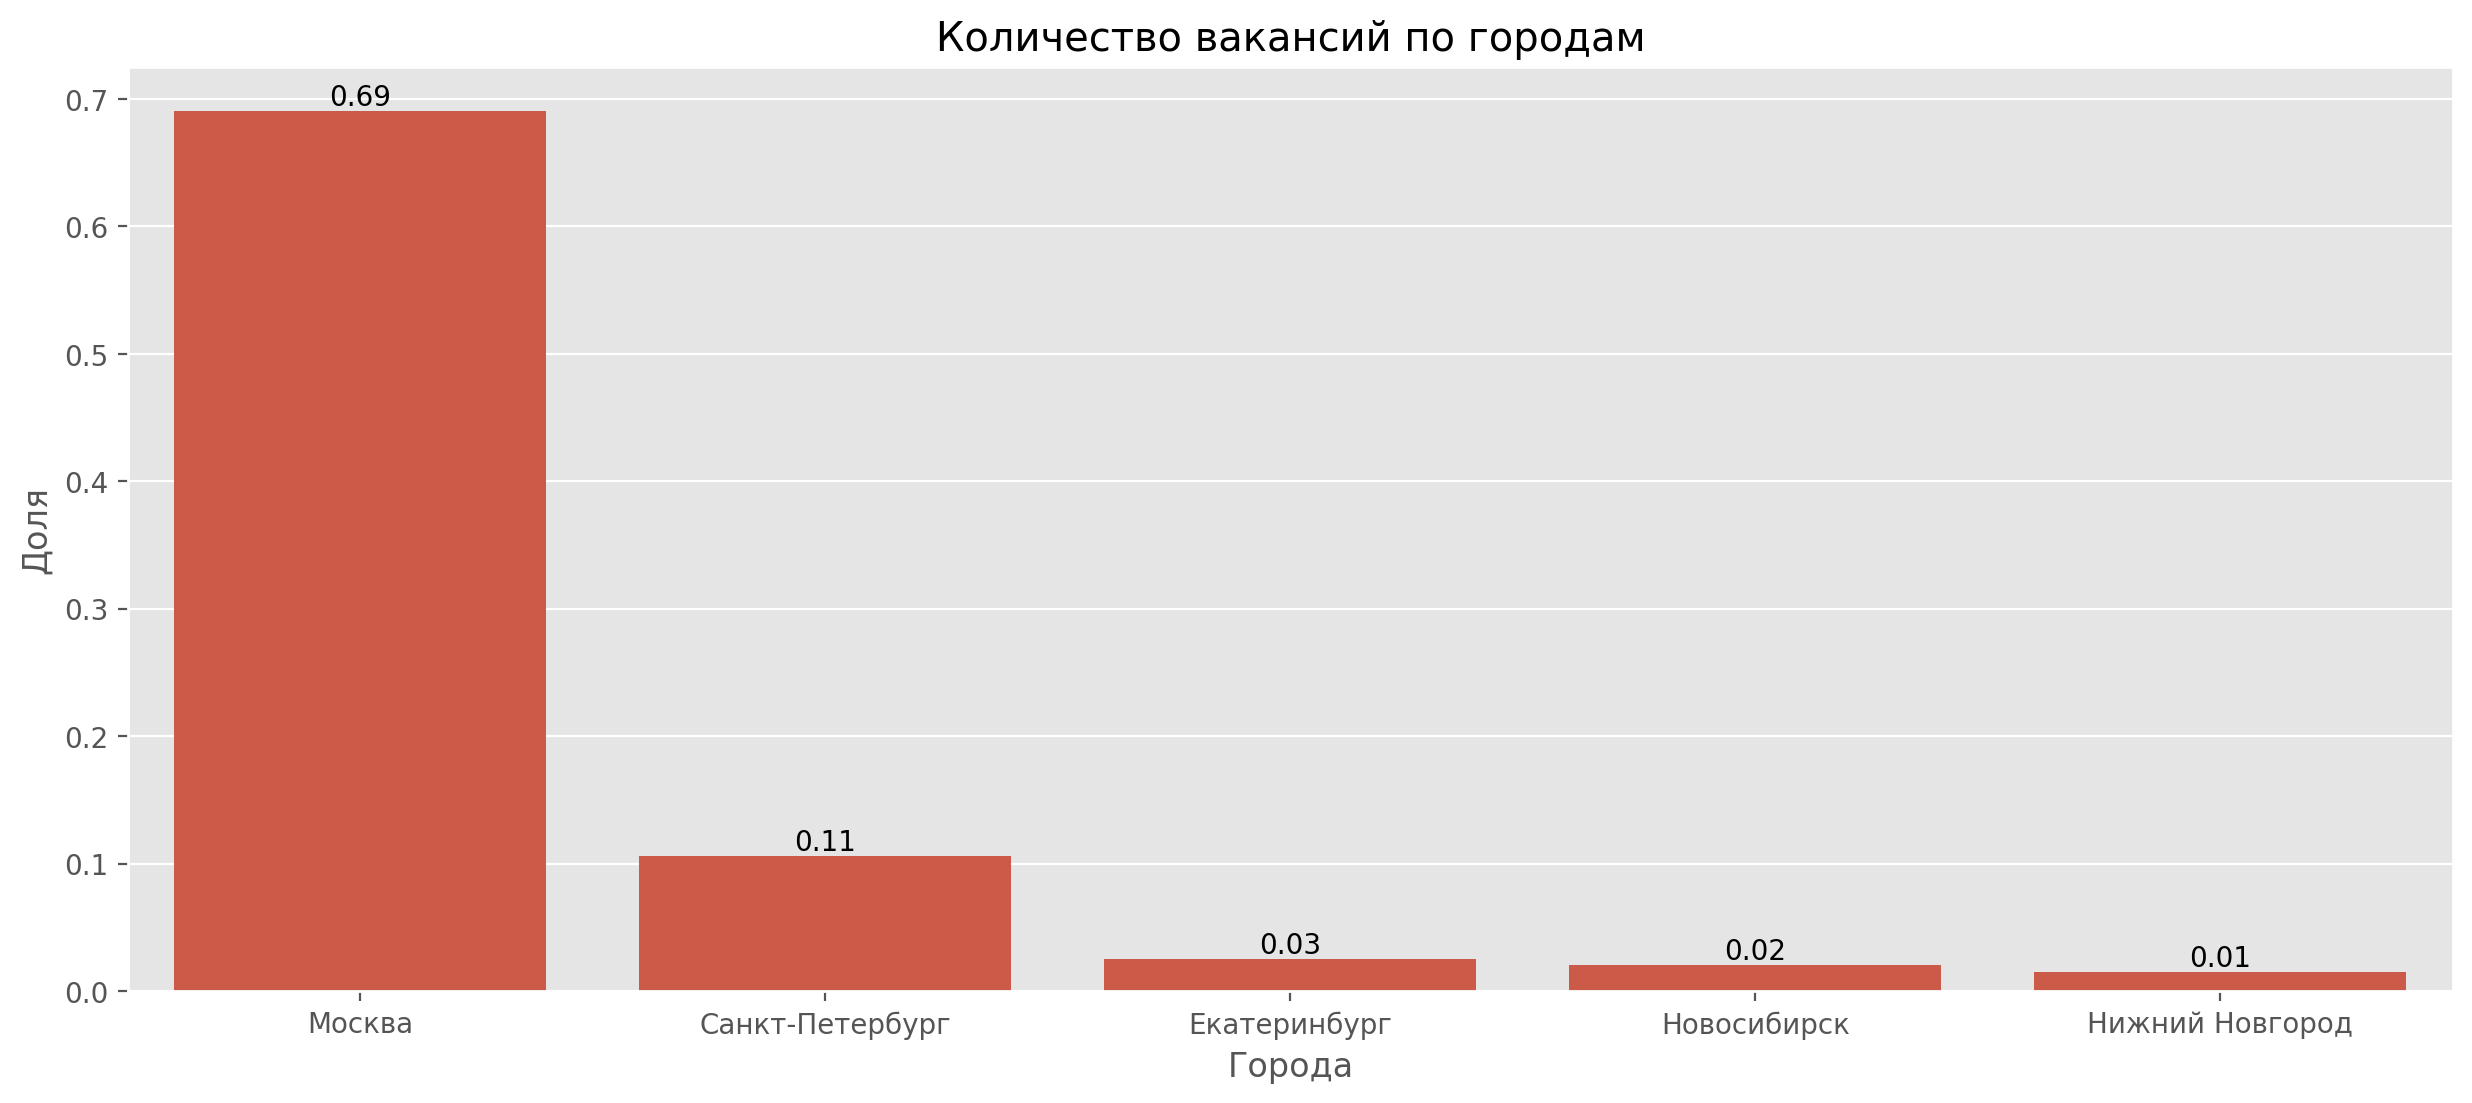

In [ ]:
# построим график с результатами из таблицы
ax = sns.barplot(da_per_city.head(5))

plt.xlabel('Города')
plt.ylabel('Доля')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Количество вакансий по городам')
plt.show()


Как видно, почти 69% вакансий аналитиков данных приходится на Москву. На втором месте - Санкт-Петербург с 11% вакансий.

### Количество вакансий в зависимости от опыта

Посмотрим, сколько опыта обычно нужно компаниями, а точнее, как заполняют колонку `experience`.

In [ ]:
# считаем долю вакансий в колонке experience
da['experience'].value_counts(normalize=True)


experience
От 1 года до 3 лет   0.548
От 3 до 6 лет        0.357
Нет опыта            0.073
Более 6 лет          0.022
Нет оп��та           0.000
Name: proportion, dtype: float64

Видим, что появлиась какая-то странная надпись - нет опыта. Посмотрим, что это за вакансия

In [ ]:
# сделаем вывод вакансии по условия
da.query('experience == "Нет оп��та"').head()

id         vacancy_name     schedule  experience    city  \
6837  119925006  Senior Data Analyst  Полный день  Нет оп��та  Москва   

                 employer  salary_from  salary_to      type  \
6837  «UZUM TECHNOLOGIES»          NaN        NaN  Открытая   

                                  url key_skills  \
6837  https://hh.ru/vacancy/119925006        NaN   

                                      professional_role  \
6837  [{'id': '156', 'name': 'BI-аналитик, аналитик ...   

                                            description  \
6837    Чем предстоит заниматься:  Поиск точек роста...   

                  published_at  experience_cat  predicted_salary   grade  
6837 2025-04-24 16:01:41+03:00               0         80200.000  Junior

это всего одна вакансия от компании uzum. Они хотят senior, но при этом заполняют вакансию, как "нет опыта". Удалим эту вакансию из датасета.

In [ ]:
# удаление вакансии с id 119925006
da = da[da['id'] != 119925006]

In [ ]:
# считаем долю вакансий в колонке experience
da_count_per_exp = da['experience'].value_counts(normalize=True)
da_count_per_exp

experience
От 1 года до 3 лет   0.548
От 3 до 6 лет        0.357
Нет опыта            0.073
Более 6 лет          0.022
Name: proportion, dtype: float64

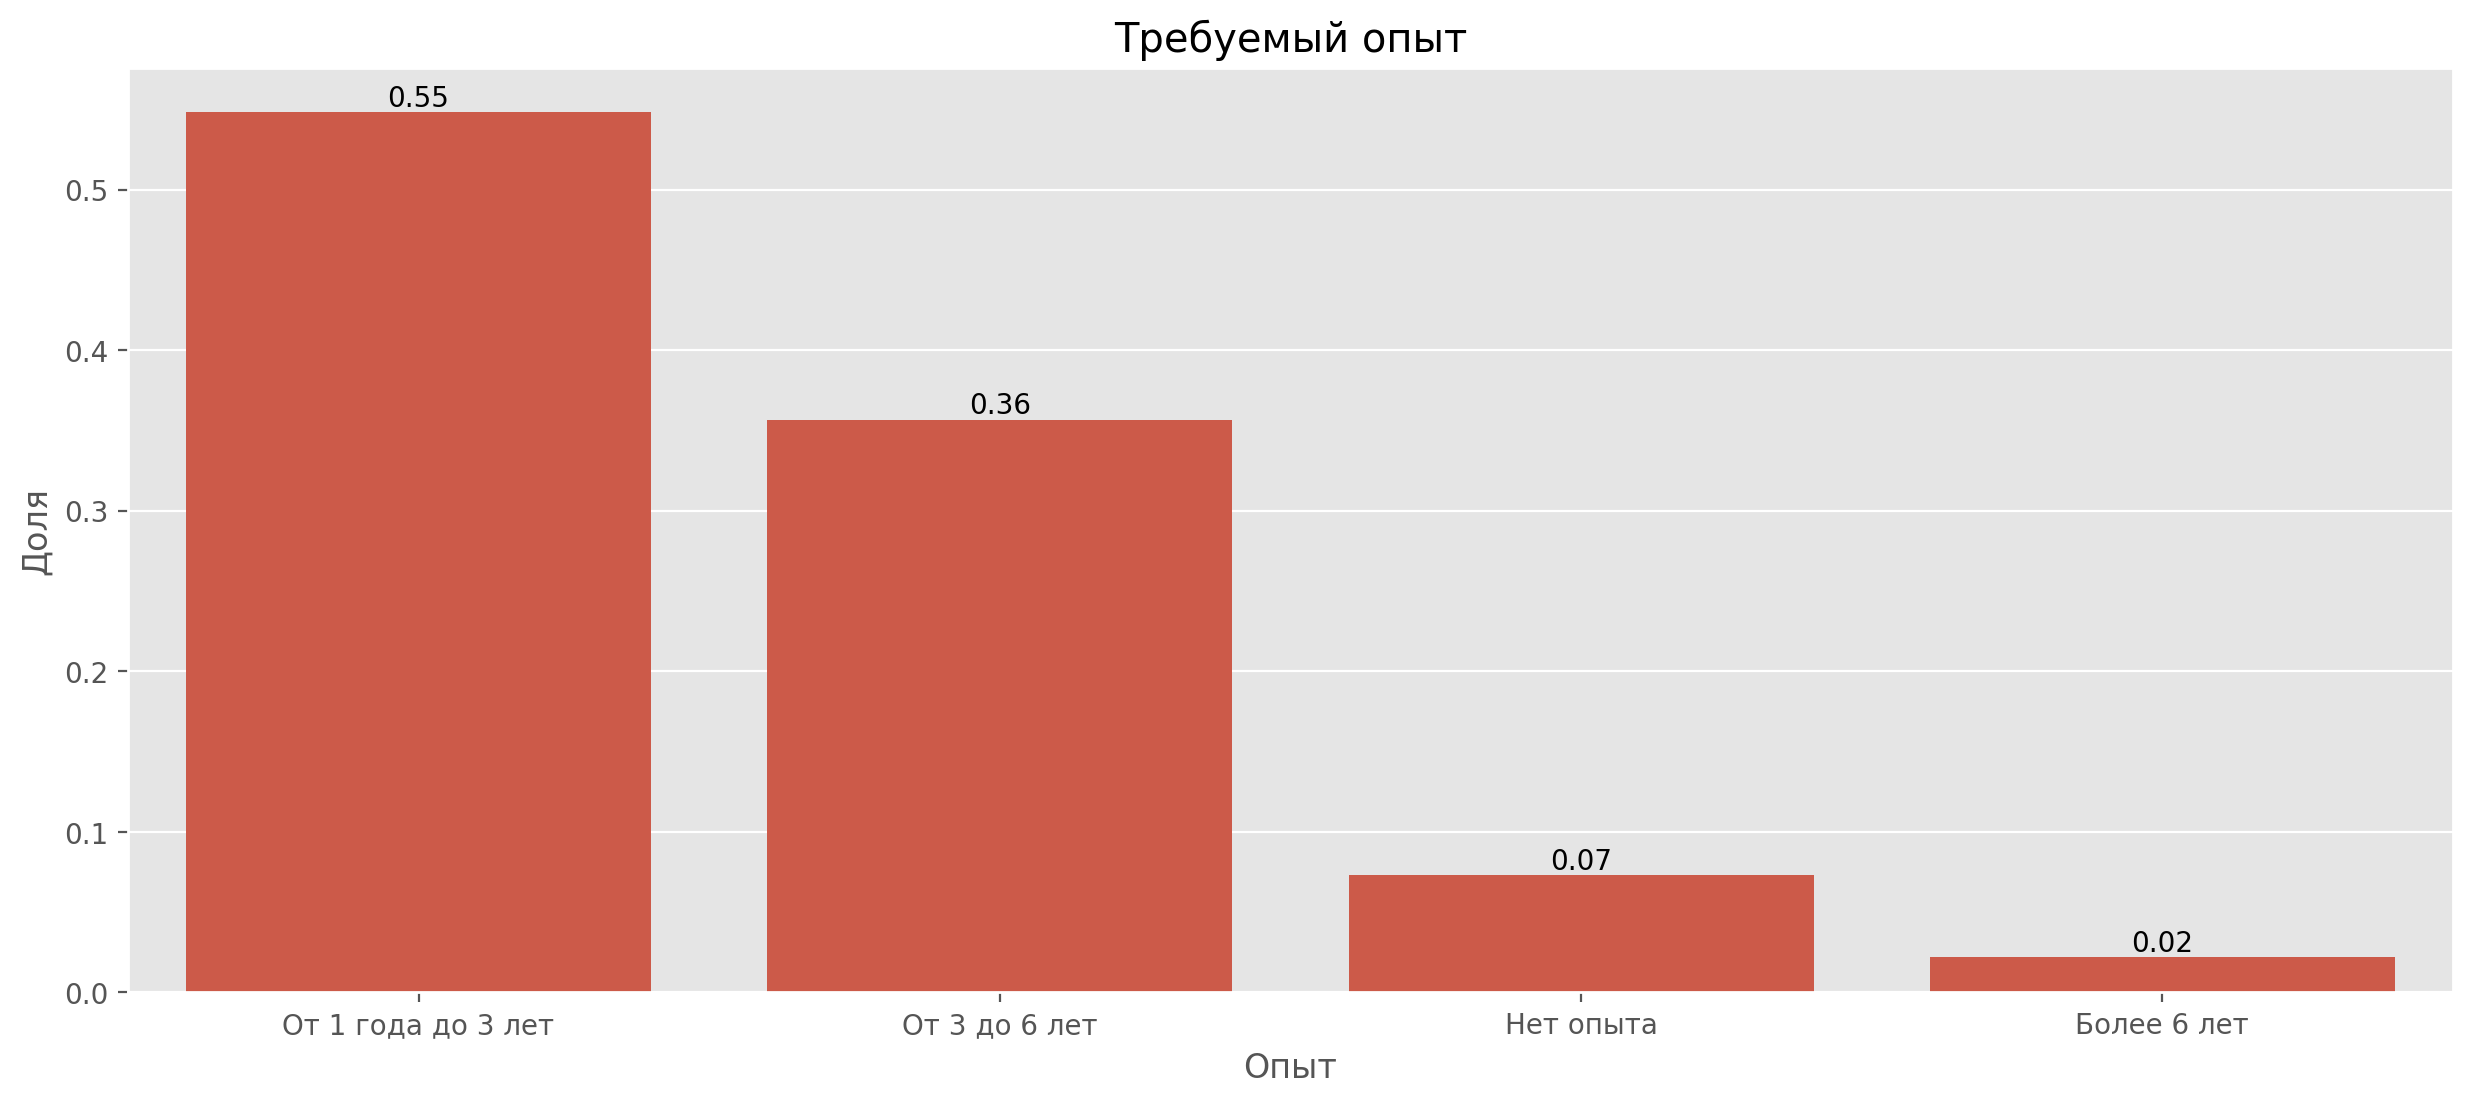

In [ ]:
# построим график с результатами из таблицы
ax = sns.barplot(da_count_per_exp)

plt.xlabel('Опыт')
plt.ylabel('Доля')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Требуемый опыт')
plt.show()


Как видно, что из общего числа вакансий чаще всего на hh.ru публикуют вакансии с требованием опыта работы от 1 до 3 лет - их 55% от общего числа. А реже всего - более 6 лет - всего 2%.

Посмотрим, на разбиение требований опыта по городам из топ 5 по количеству вакансий.

In [ ]:
# оставим в датасете только вакансии из городов их топ-5
top_cities = da[da['city'].isin(da_per_city.head(5).index)]
top_cities['city'].value_counts()

city
Москва             6272
Санкт-Петербург     962
Екатеринбург        228
Новосибирск         184
Нижний Новгород     132
Name: count, dtype: int64

In [ ]:
# группируем по городам и опыту
city_exp = top_cities.groupby(['city', 'experience'])['id'].count().reset_index()
city_exp

city          experience    id
0      Екатеринбург         Более 6 лет     1
1      Екатеринбург           Нет опыта    13
2      Екатеринбург  От 1 года до 3 лет   143
3      Екатеринбург       От 3 до 6 лет    71
4            Москва         Более 6 лет   166
5            Москва           Нет опыта   335
6            Москва  От 1 года до 3 лет  3245
7            Москва       От 3 до 6 лет  2526
8   Нижний Новгород         Более 6 лет     2
9   Нижний Новгород           Нет опыта    23
10  Нижний Новгород  От 1 года до 3 лет    73
11  Нижний Новгород       От 3 до 6 лет    34
12      Новосибирск           Нет опыта    25
13      Новосибирск  От 1 года до 3 лет   116
14      Новосибирск       От 3 до 6 лет    43
15  Санкт-Петербург         Более 6 лет    21
16  Санкт-Петербург           Нет опыта    64
17  Санкт-Петербург  От 1 года до 3 лет   550
18  Санкт-Петербург       От 3 до 6 лет   327

In [ ]:
# Сортировка городов по убыванию количества вакансий
city_exp_sorted = city_exp.sort_values(by='id', ascending=False).reset_index(drop=True)
city_exp_sorted['city'] = pd.Categorical(city_exp_sorted['city'], categories=city_exp_sorted['city'].unique(), ordered=True)

# Вычисление процентного соотношения для каждого опыта в городе
city_exp_sorted['total_id'] = city_exp_sorted.groupby('city')['id'].transform('sum')
city_exp_sorted['percentage'] = (city_exp_sorted['id'] / city_exp_sorted['total_id']) * 100

city_exp_sorted

/tmp/ipython-input-101-3781490931.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_exp_sorted['total_id'] = city_exp_sorted.groupby('city')['id'].transform('sum')


city          experience    id  total_id  percentage
0            Москва  От 1 года до 3 лет  3245      6272      51.738
1            Москва       От 3 до 6 лет  2526      6272      40.274
2   Санкт-Петербург  От 1 года до 3 лет   550       962      57.173
3            Москва           Нет опыта   335      6272       5.341
4   Санкт-Петербург       От 3 до 6 лет   327       962      33.992
5            Москва         Более 6 лет   166      6272       2.647
6      Екатеринбург  От 1 года до 3 лет   143       228      62.719
7       Новосибирск  От 1 года до 3 лет   116       184      63.043
8   Нижний Новгород  От 1 года до 3 лет    73       132      55.303
9      Екатеринбург       От 3 до 6 лет    71       228      31.140
10  Санкт-Петербург           Нет опыта    64       962       6.653
11      Новосибирск       От 3 до 6 лет    43       184      23.370
12  Нижний Новгород       От 3 до 6 лет    34       132      25.758
13      Новосибирск           Нет опыта    25       184      13.587
14  Нижний Новгород           Нет опыта    23       132      17.424
15  Санкт-Петербург         Более 6 лет    21       962       2.183
16     Екатеринбург           Нет опыта    13       228       5.702
17  Нижний Новгород         Более 6 лет     2       132       1.515
18     Екатеринбург         Более 6 лет     1       228       0.439

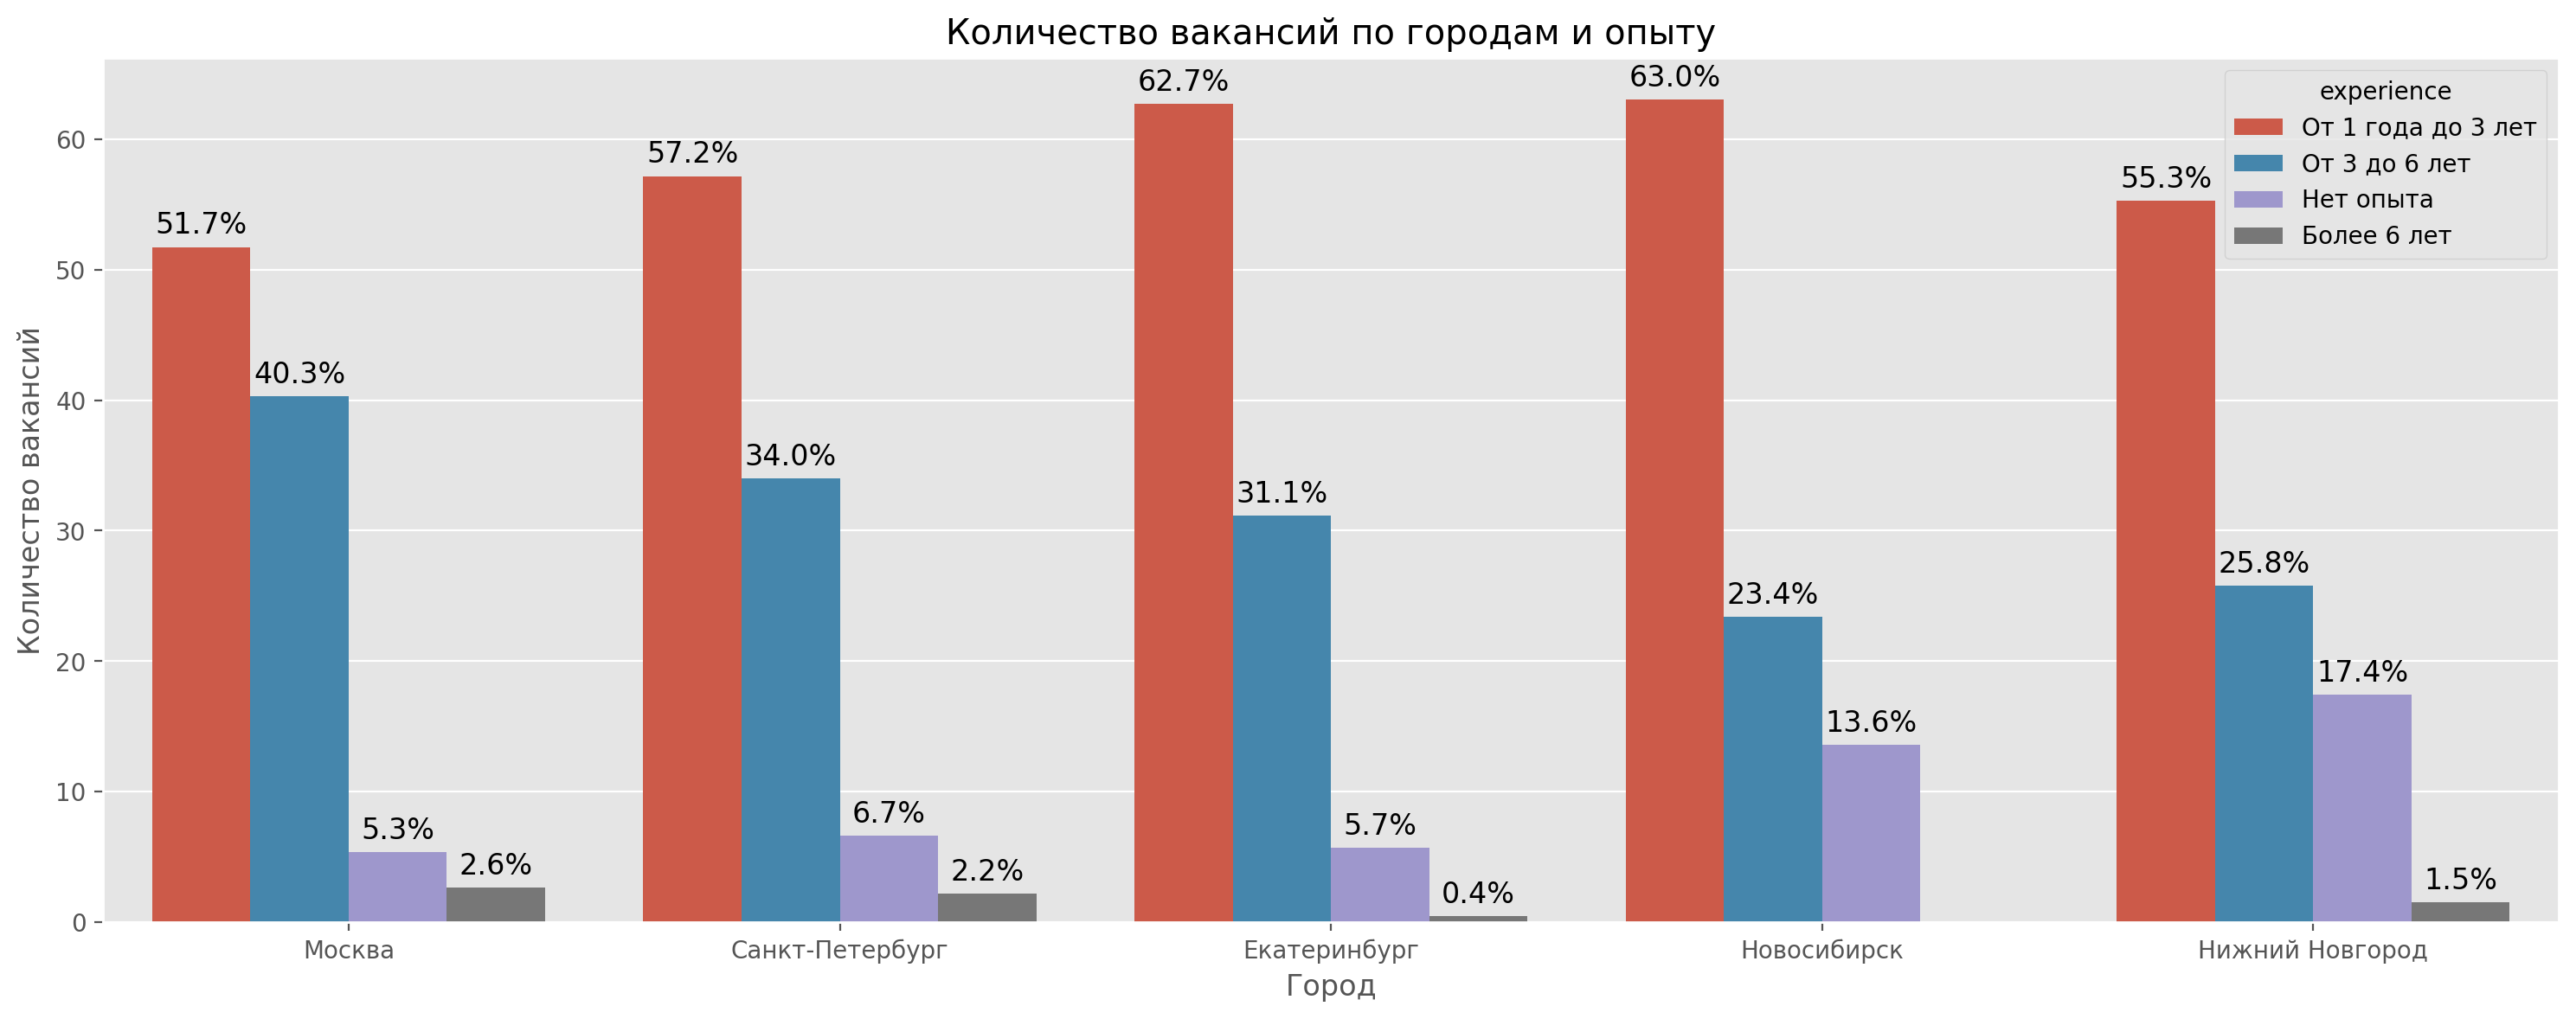

In [ ]:
# построим график по распределению количества вакансий по городам и опыту
ax = sns.barplot(x='city', y='percentage', hue='experience', data=city_exp_sorted)

plt.xlabel('Город')
plt.ylabel('Количество вакансий')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)

plt.title('Количество вакансий по городам и опыту')
plt.tight_layout()
plt.show()

1. Наибольший % от всех вакансий города с опытом от 1 до 3 лет прихожится на Новосибирск и Екатеринбург. Наименьшая - Москва.
2. В Москве работодатели больше хотят видеть работников с большим опытом, чем в других городах. 40% вакансий требуют опыта от 3 до 6 лет.
3. Работников без опыта в Нижнем Новгороде охотнее принимают на работу. В нем доля вакансий "без опыта" - 17.4%.
4. Наименьшее количество вакансий с опытом более 6 лет. Что говорит о том, что с таким опытом людей ищут в других источниках.

### Топ-5 работодателей

Посмотрим, кто больше всего публикует вакансий

In [ ]:
# сгруппируем по employer, выведем топ-5 и посчитаем количество вакансий
top_employers = (da.groupby('employer')['id'].count()
                   .sort_values(ascending=False)
                   .head(5)
                   .reset_index())

top_employers.columns = ['employer', 'count']
top_employers

employer  count
0            СБЕР    496
1            Ozon    210
2          Яндекс    174
3  Банк ВТБ (ПАО)    127
4     WILDBERRIES    104

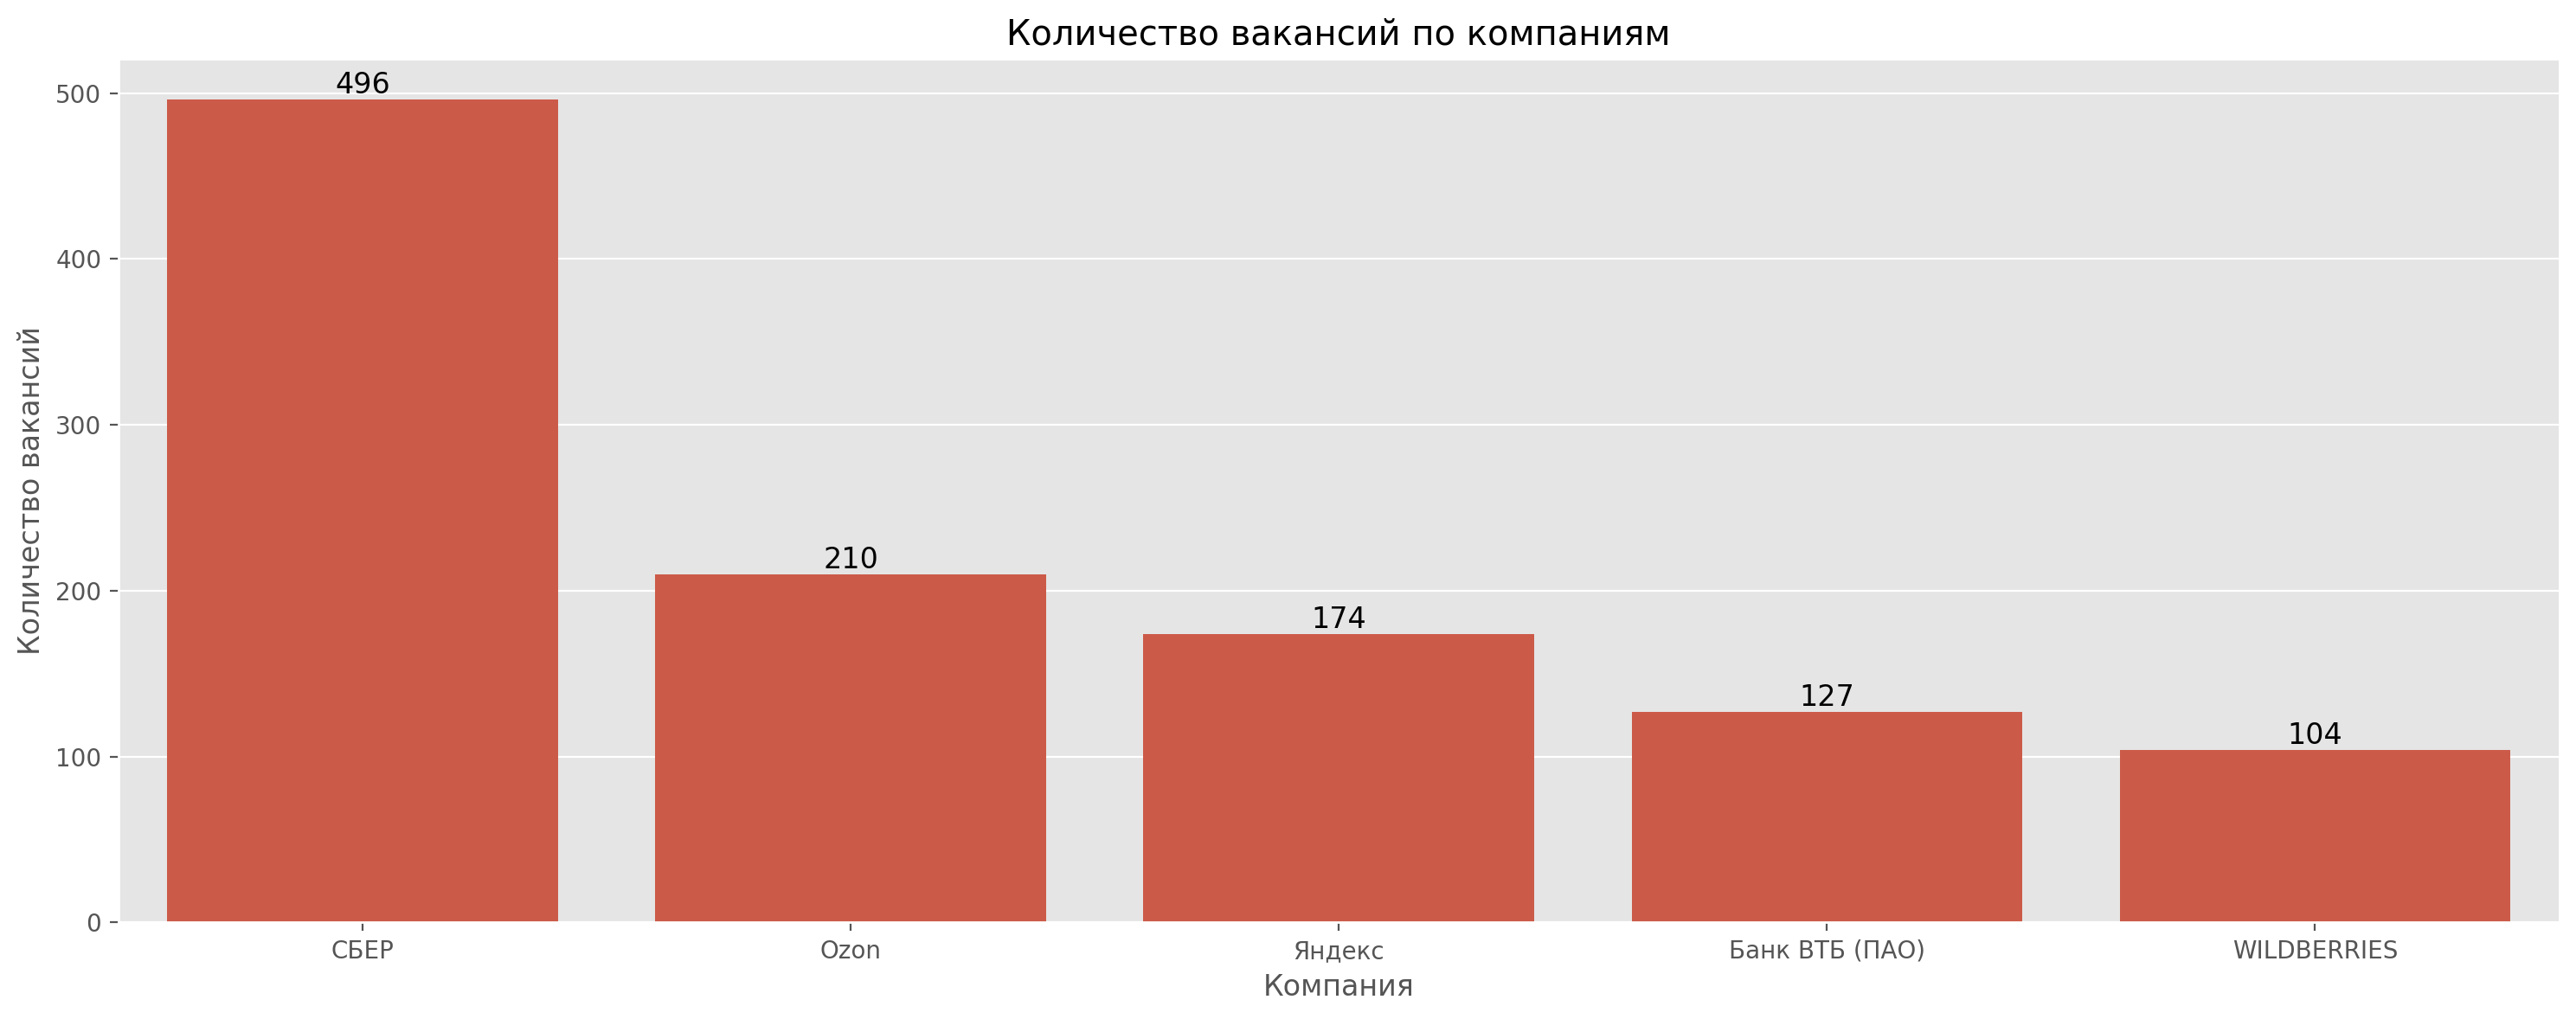

In [ ]:
# построим график
ax = sns.barplot(x='employer', y='count', data=top_employers)

plt.xlabel('Компания')
plt.ylabel('Количество вакансий')

ax.bar_label(ax.containers[0], fontsize=12)

plt.title('Количество вакансий по компаниям')
plt.tight_layout()
plt.show()

Топ-5 компаний - СБЕР, Озон, Яндекс, ВТБ и Вайлдберриз.

А теперь посмотрим, какой опыт в вакансиях они требуют.

In [ ]:
# оставим в датасете только вакансии для топ-5 работодателей
top_employer_df = da[da['employer'].isin(top_employers['employer'])]
top_employer_df['employer'].value_counts()

employer
СБЕР              496
Ozon              210
Яндекс            174
Банк ВТБ (ПАО)    127
WILDBERRIES       104
Name: count, dtype: int64

In [ ]:
# группируем по компаниям и опыту
top_employers_exp = top_employer_df.groupby(['employer', 'experience'])['id'].count().reset_index()
top_employers_exp

employer          experience   id
0             Ozon         Более 6 лет    5
1             Ozon           Нет опыта   10
2             Ozon  От 1 года до 3 лет  142
3             Ozon       От 3 до 6 лет   53
4      WILDBERRIES         Более 6 лет    9
5      WILDBERRIES           Нет опыта    2
6      WILDBERRIES  От 1 года до 3 лет   45
7      WILDBERRIES       От 3 до 6 лет   48
8   Банк ВТБ (ПАО)           Нет опыта   11
9   Банк ВТБ (ПАО)  От 1 года до 3 лет   82
10  Банк ВТБ (ПАО)       От 3 до 6 лет   34
11            СБЕР         Более 6 лет   20
12            СБЕР           Нет опыта   34
13            СБЕР  От 1 года до 3 лет  274
14            СБЕР       От 3 до 6 лет  168
15          Яндекс         Более 6 лет    4
16          Яндекс           Нет опыта    3
17          Яндекс  От 1 года до 3 лет   21
18          Яндекс       От 3 до 6 лет  146

In [ ]:
# Вычисление процентного соотношения для каждого опыта в компании
top_employers_exp['total_id'] = top_employers_exp.groupby('employer')['id'].transform('sum')
top_employers_exp['percentage'] = (top_employers_exp['id'] / top_employers_exp['total_id']) * 100

# Сортировка компаний по убыванию количества вакансий
top_employers_exp_sorted = top_employers_exp.sort_values(by='total_id', ascending=False).reset_index(drop=True)

top_employers_exp_sorted['employer'] = pd.Categorical(top_employers_exp_sorted['employer'],
                                                      categories=top_employers_exp_sorted['employer'].unique(),
                                                      ordered=True)
top_employers_exp_sorted

employer          experience   id  total_id  percentage
0             СБЕР           Нет опыта   34       496       6.855
1             СБЕР  От 1 года до 3 лет  274       496      55.242
2             СБЕР       От 3 до 6 лет  168       496      33.871
3             СБЕР         Более 6 лет   20       496       4.032
4             Ozon  От 1 года до 3 лет  142       210      67.619
5             Ozon         Более 6 лет    5       210       2.381
6             Ozon           Нет опыта   10       210       4.762
7             Ozon       От 3 до 6 лет   53       210      25.238
8           Яндекс  От 1 года до 3 лет   21       174      12.069
9           Яндекс           Нет опыта    3       174       1.724
10          Яндекс         Более 6 лет    4       174       2.299
11          Яндекс       От 3 до 6 лет  146       174      83.908
12  Банк ВТБ (ПАО)           Нет опыта   11       127       8.661
13  Банк ВТБ (ПАО)       От 3 до 6 лет   34       127      26.772
14  Банк ВТБ (ПАО)  От 1 года до 3 лет   82       127      64.567
15     WILDBERRIES       От 3 до 6 лет   48       104      46.154
16     WILDBERRIES         Более 6 лет    9       104       8.654
17     WILDBERRIES           Нет опыта    2       104       1.923
18     WILDBERRIES  От 1 года до 3 лет   45       104      43.269

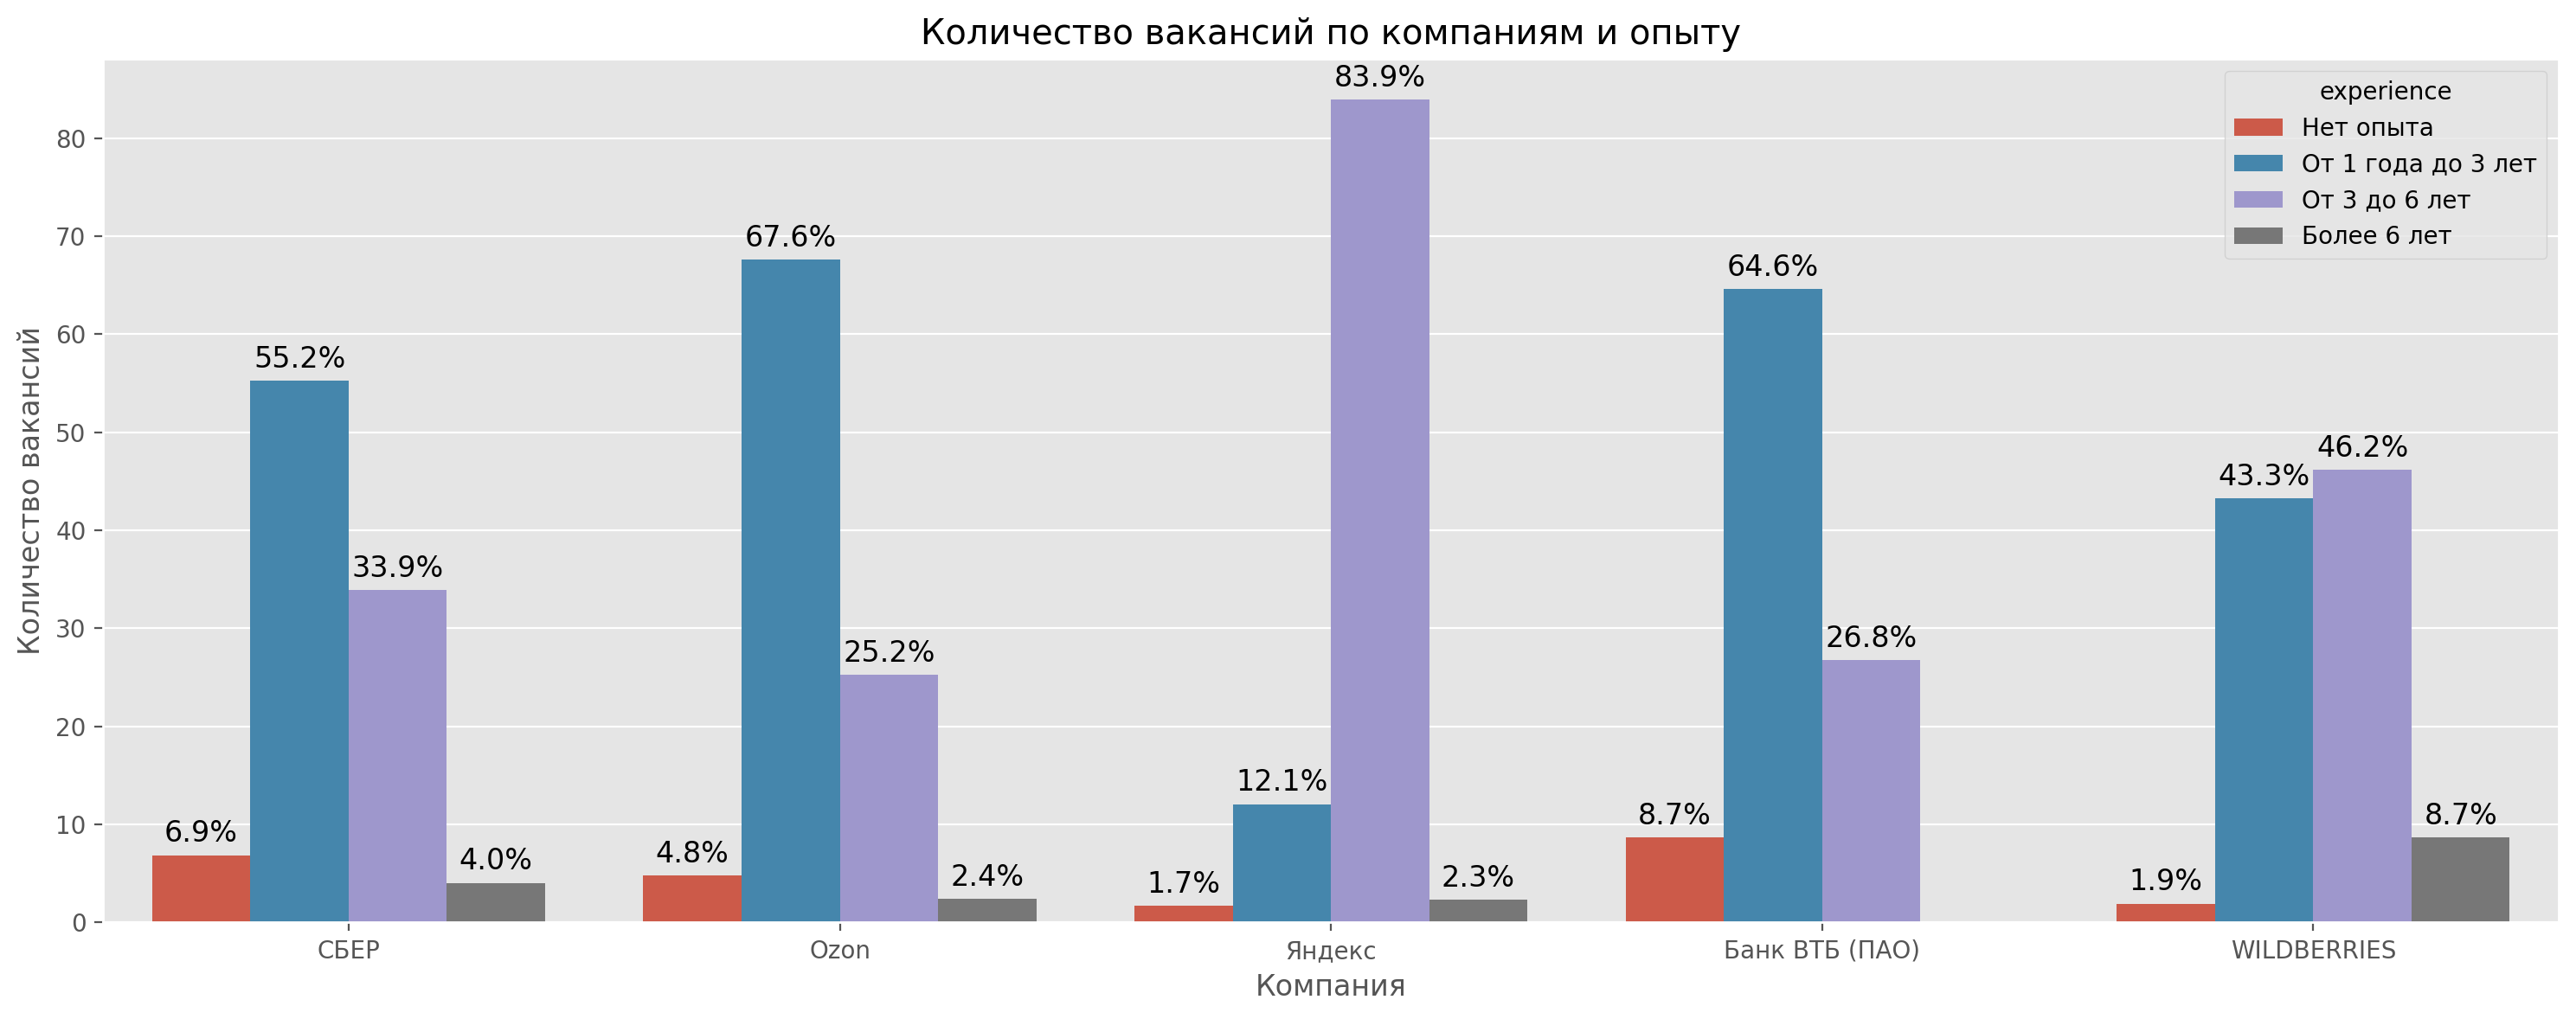

In [ ]:
# построим график по распределению количества вакансий по городам и опыту
ax = sns.barplot(x='employer', y='percentage', hue='experience', data=top_employers_exp_sorted)

plt.xlabel('Компания')
plt.ylabel('Количество вакансий')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)

plt.title('Количество вакансий по компаниям и опыту')
plt.tight_layout()
plt.show()

1. Яндекс набирает в основном опытных аналитиков с опытов от 3 до 6 лет - 83.9% вакансий.
2. Компании СБЕР, Озон и ВТБ больше отдают предпочтение с опытом 1-3 - 55.2% 67.6% и 64.6%, соответственно.
3. Вайлдберриз ищет аналитиков с опытом от 1 до 3 и от 3 до 6 примерно в одних процентах - по 43.3% и 46.2%, соответственно.  
4. Наиболее часто без опыта берут в ВТБ - 8.7% вакансий. На втором месте - СБЕР с 6.9%.

### Количество публикаций в зависимости от дня недели

In [ ]:
# Выделим id вакансий и время
da_time = da[['id', 'published_at']].copy()

da_time.head()

id              published_at
0  79889558 2024-12-16 14:04:49+03:00
1  85216340 2025-01-23 13:52:22+03:00
2  86004285 2024-12-04 15:09:33+03:00
3  86617759 2024-10-08 17:38:44+03:00
4  86906212 2025-02-03 10:20:39+03:00

In [ ]:
da_time['day_of_week'] = da_time.loc[:, 'published_at'].dt.weekday

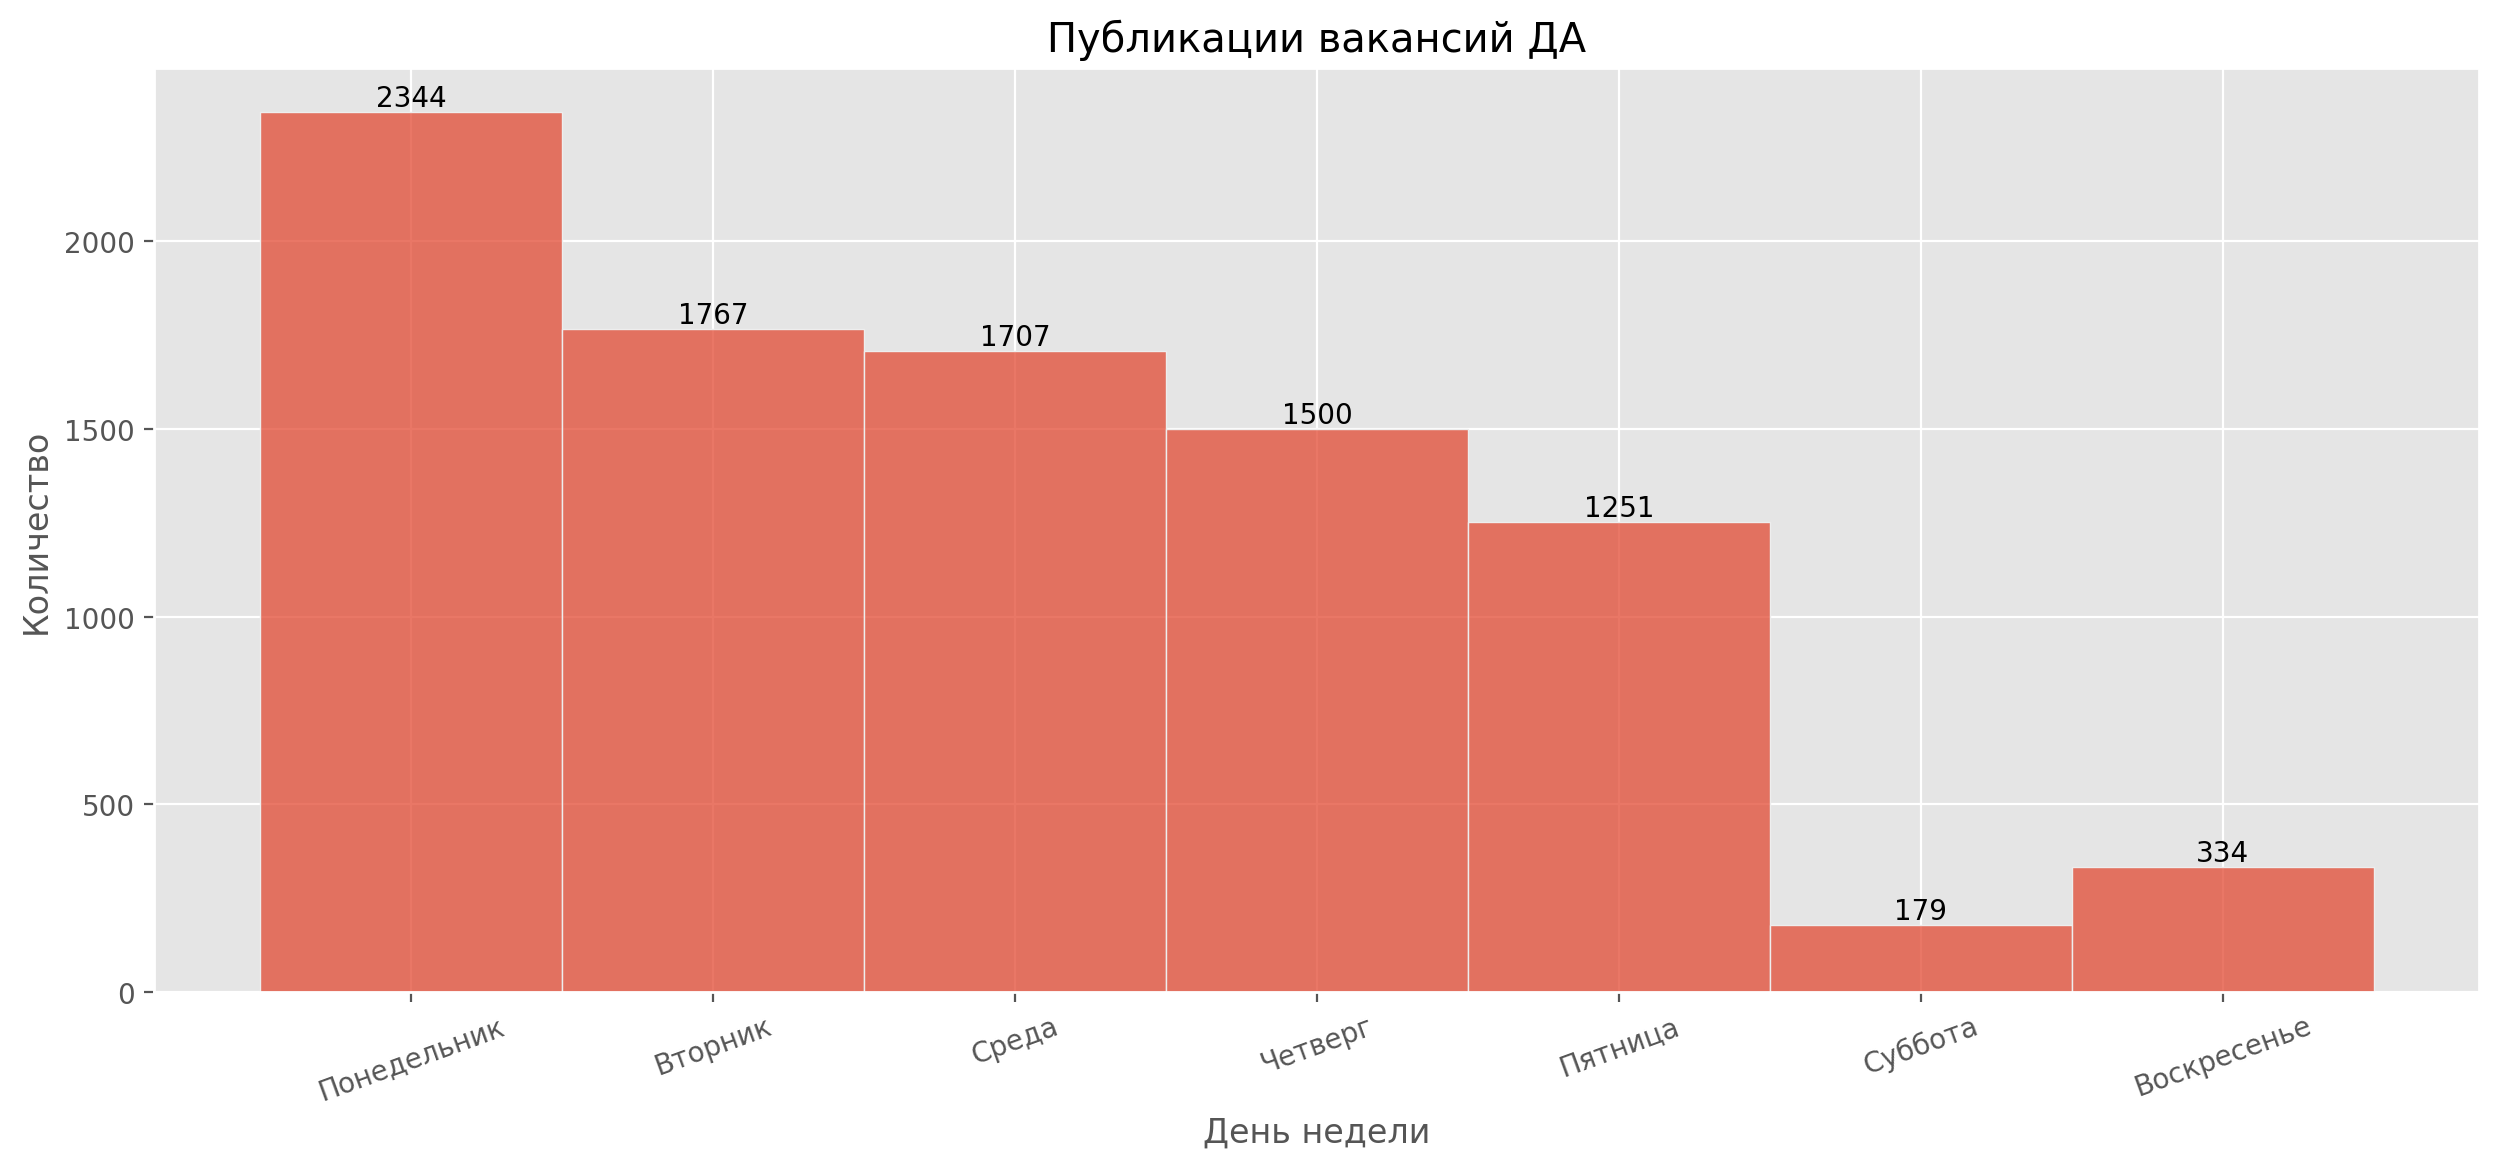

In [ ]:
day_dict = {0: 'Понедельник',
            1: 'Вторник',
            2: 'Среда',
            3: 'Четверг',
            4: 'Пятница',
            5: 'Суббота',
            6: 'Воскресенье'}

ax = sns.histplot(data=da_time['day_of_week'], discrete=True)
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.title('Публикации вакансий ДА')
plt.xticks(list(range(7)), labels=day_dict.values(), rotation=20)
ax.bar_label(ax.containers[0])


plt.show()

Как видно, наибольшее количество вакансий появляется в понедельник. Затем идет плавное снижение до конца рабочей недели.

Посмотрим, есть ли зависимость от часа публикации

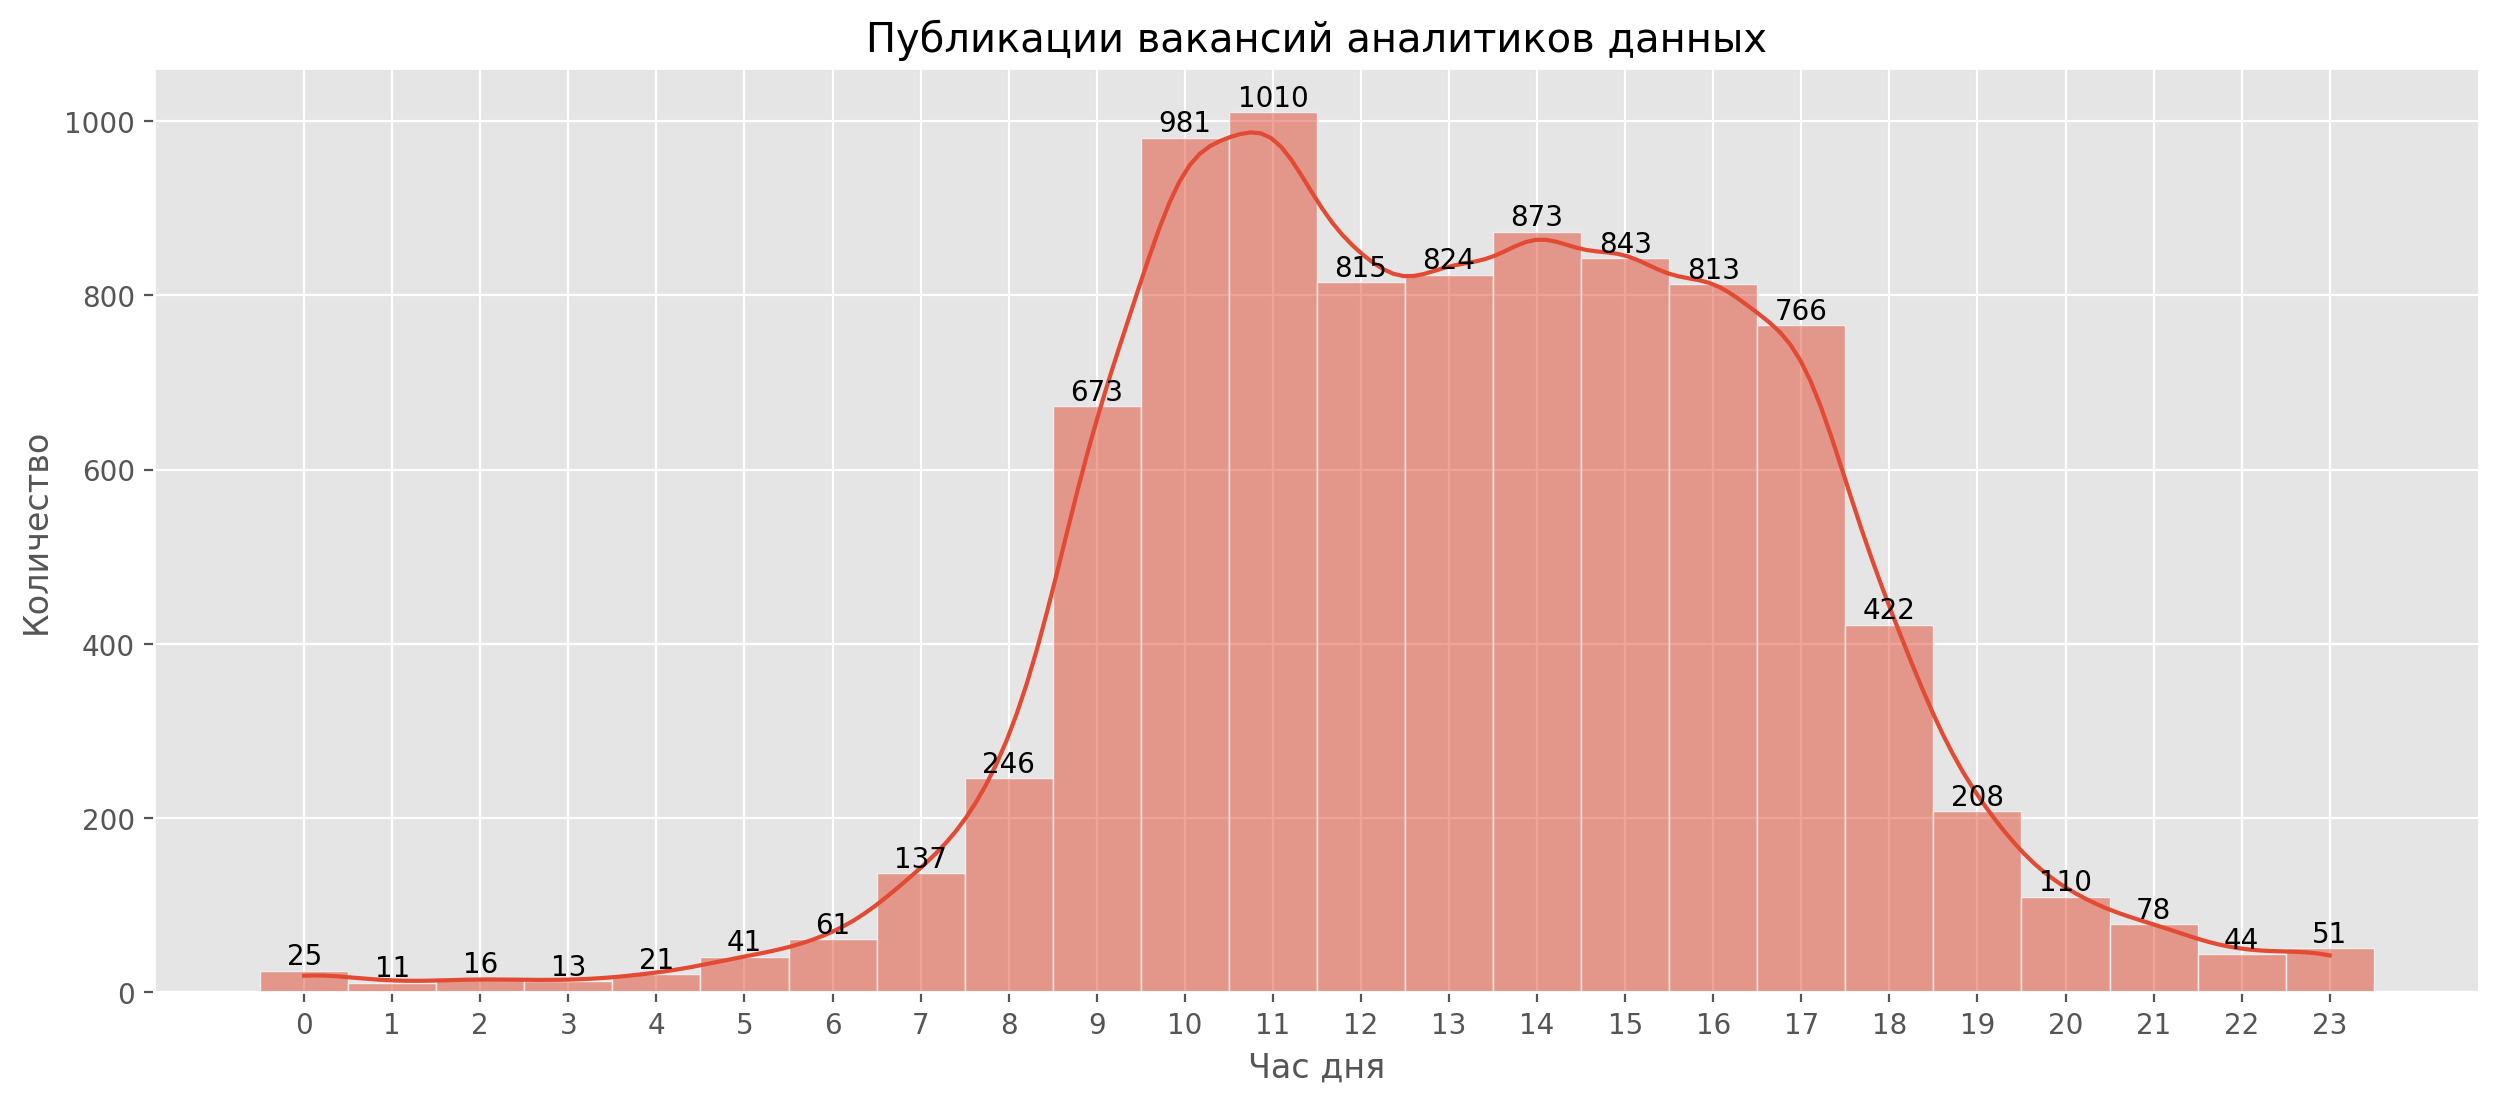

In [ ]:
da_time['hour'] = da_time.loc[:, 'published_at'].dt.hour

ax = sns.histplot(data=da_time['hour'], discrete=True, kde=True)
plt.xlabel('Час дня')
plt.ylabel('Количество')
plt.title('Публикации вакансий аналитиков данных')
plt.xticks(list(range(24)), labels=list(range(24)))
ax.bar_label(ax.containers[0])

plt.show()

1. Зависимость публикаций от времени часа тоже есть.
2. Наибольшее число вакансий публикуются с 10 до 11 по Москве.

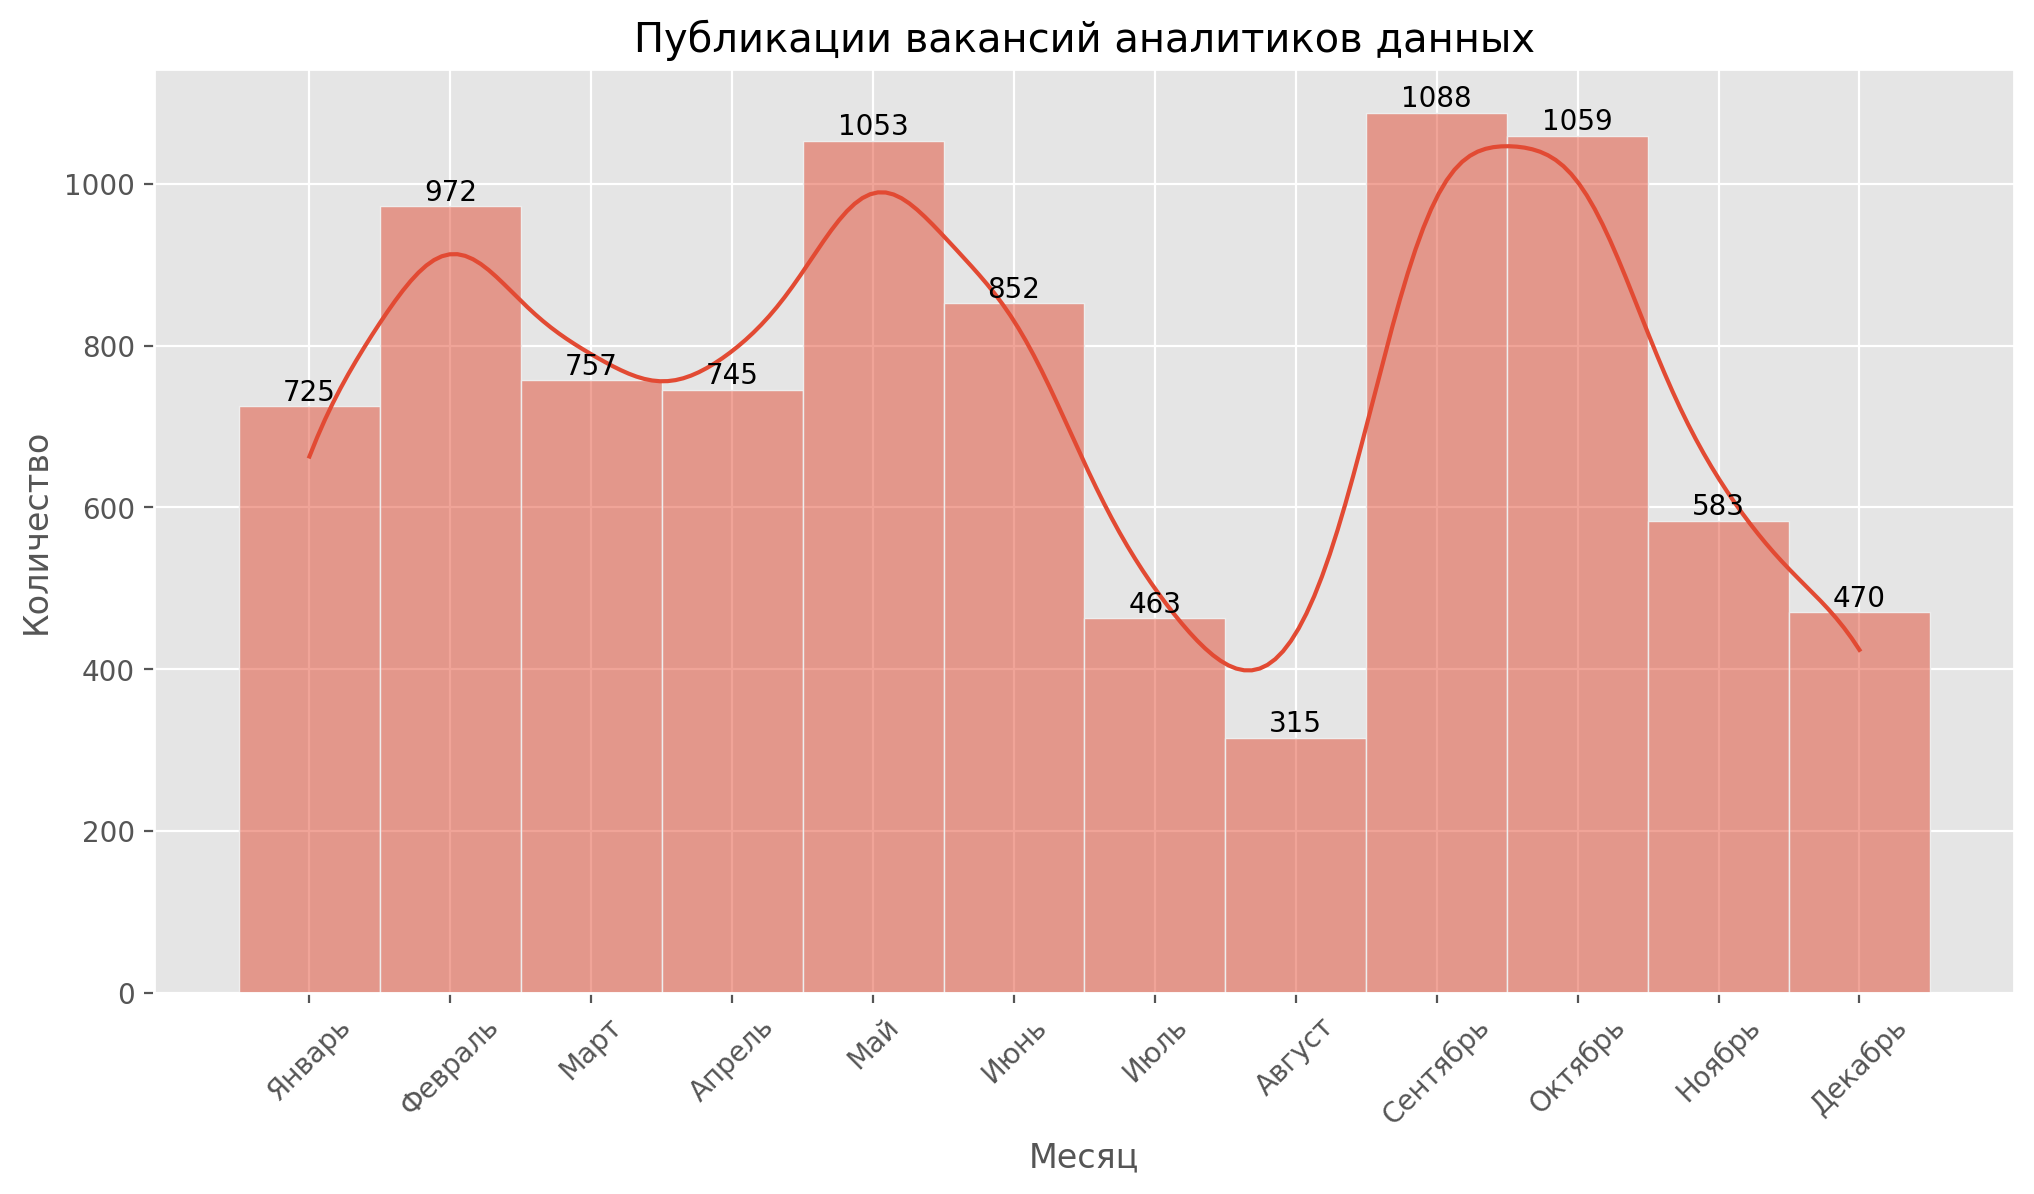

In [ ]:
# выделим месяц публикации вакансий
da_time['month'] = da_time.loc[:, 'published_at'].dt.month

month_dict = {
    1: 'Январь', 2: 'Февраль', 3: 'Март',
    4: 'Апрель', 5: 'Май', 6: 'Июнь',
    7: 'Июль', 8: 'Август', 9: 'Сентябрь',
    10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'}

plt.figure(figsize=(12, 6))
ax = sns.histplot(data=da_time['month'], discrete=True, kde=True)

plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.title('Публикации вакансий аналитиков данных')
plt.xticks(ticks=range(1, 13), labels=month_dict.values(), rotation=45)
ax.bar_label(ax.containers[0])


plt.show()

1. Наименьшее число вакансий наблюдается в августе и июле - 315 и 463, соответственно.
2. Наибольшее количество - май (1053), сентябрь (1088) и октябрь (1059).
Также есть увеличение количества вакансий в феврале.
Данные за июль и август еще необходимо проверить, так как активный мониторинг вакансий осуществлялся с сентября.

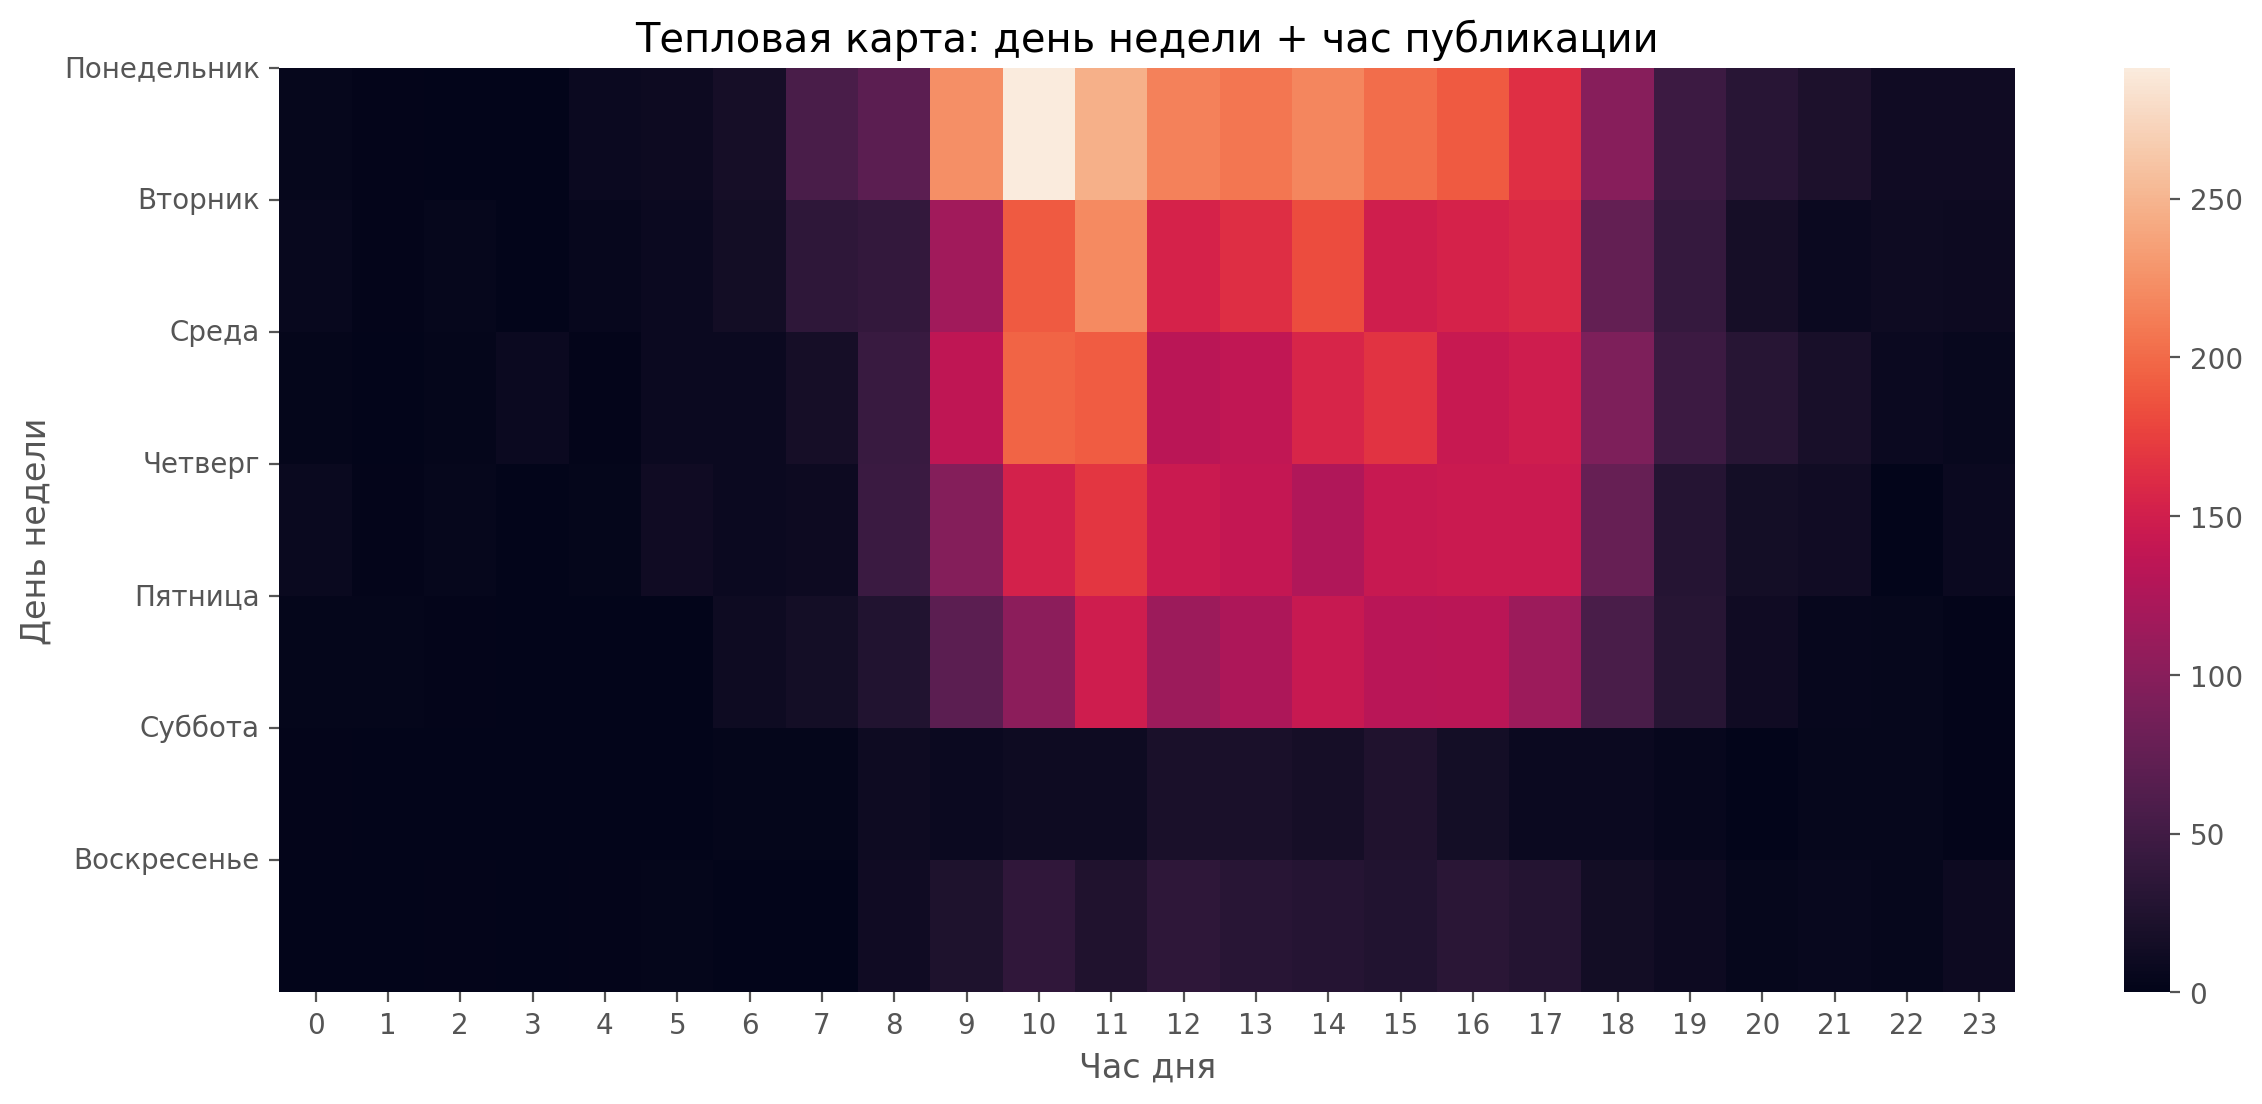

In [ ]:
# Создаем таблицу количества публикаций по дням недели и часам
heatmap_data = da_time.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=False)
plt.title("Тепловая карта: день недели + час публикации")
plt.xlabel("Час дня")
plt.ylabel("День недели")
plt.yticks(ticks=range(7), labels=day_dict.values(), rotation=0)
plt.show()

Тепловая карта публикаций вакансий показывает, что наибольшее количество вакансий публикуется в 10 часов в понедельник. Также виден диапазон частых публикаций - с 9 до 16, с понедельника по пятницу включительно.

#### **Краткий вывод по анализу вакансий аналитиков данных на hh.ru**  

**1. Распределение вакансий по городам**  
- 69% вакансий сосредоточено в Москве, на втором месте Санкт-Петербург (11%).  
- Новосибирск и Екатеринбург лидируют по доле вакансий с опытом 1–3 года, а Москва чаще требует 3–6 лет (40%).  
- Нижний Новгород выделяется наибольшей долей вакансий без опыта (17,4%).  
- Вакансий с опытом более 6 лет крайне мало 2 что может указывать на поиск таких специалистов в других источниках.  

**2. Требования к опыту работы**  
- 55 вакансий рассчитаны на специалистов с опытом 1–3 года, реже всего требуются кандидаты с более 6 лет опыта (2%).
- Яндекс чаще нанимает аналитиков с 3–6 лет опыта (83,9%), а СБЕР, Озон и ВТБ — с 1–3 года (55–67%).  
- ВТБ чаще других берет без опыта (8,7%), следом идет СБЕР (6,9%).  

**3. Динамика публикации вакансий**  
- Пик публикаций — 10–11 утра по Москве.  
- Наибольшее число вакансий в мае, сентябре и октябре (1000+), наименьшее — в  июле и августе (возможно, из-за неполных данных).  
- Тепловая карта показывает максимум публикаций в 10 утра по понедельникам, активность сохраняется с 9 до 16 часов в будни.  

**Вывод**  
Большинство вакансий аналитиков данных сосредоточено в Москве, чаще требуются специалисты с 1–3 годами опыта. Крупные компании (СБЕР, Озон, ВТБ, Яндекс, Вайлдберриз) формируют основной спрос, причем Яндекс ориентирован на более опытных кандидатов. Публикации вакансий наиболее активны в первой половине дня по будням, с сезонными пиками весной и осенью.

## Навыки, требуемые в вакансиях

Выделим навыки, которые указывают в вакансиях

In [ ]:
# заполняем значения NaN пустыми строками
da['key_skills'] = da['key_skills'].fillna('')
# изменение типа данных в список
da['key_skills'] = da['key_skills'].apply(lambda x: x.split(', '))

Посмотрим, какие навыки чаще всего упоминаются в требуемых

In [ ]:
# напишем функцию подсчета навыков.
# функция принимает определенную колонку датасета
# и выводит 10 навыков в виде объекта Series
# отсортированные по количеству упоминаний
def skills_count(data):
  sum_skills = []
  for skill in data:
      for el in skill:
            if el != '':
                 sum_skills.append(re.sub('\'', '', el.lower()))
  return pd.Series(Counter(sum_skills)).sort_values(ascending=False).head(10)

In [ ]:
# вызываем функцию
skills_count(da['key_skills'])

sql                       3374
python                    2325
power bi                  1345
ms excel                   934
анализ данных              915
аналитическое мышление     875
не указано                 720
a/b тесты                  510
визуализация данных        503
ms sql                     498
dtype: int64

Из первой 10-ки видно, что встречаются синонимы: например sql и ms sql.
Выделим hard навыки в отдульную колонку и постараемся объединить такие навыки под одним названием.

In [ ]:
# функция заполнения колонки hard skills
# на вход получает колонку с навыками
# на выход заполненную колонку
def hard_skills_da(data):
    hard_skills = (['.+sql|sql.+|sql', 'python', '.+bi|bi', 'pandas', '.+excel.+',
                'confluence', '.+статистик.+',
                'a/b тесты', 'ms.+', 'английский язык',
                'сводные таблицы', 'базы данных', 'etl', 'clickhouse',
                'tableau', '.+анализ.+', 'hadoop', 'data analysis'])

    skills = []
    for i in data:
        i = re.sub('\'', '', i.lower())
        for skill in hard_skills:

            skills += re.findall(skill, i)

    return skills

da['hard_skills_from_description'] = da['key_skills'].apply(hard_skills_da)

In [ ]:
# объединим похожие навыки в соответствии со словарем
skill_groups = {
    'sql': ['sql', 'ms sql', 'postgresql', 'oracle', 'greenplum', 'mysql', 'mssql', 'sqlite', 'основы баз данных'],
    'python': ['python', 'pandas', 'numpy'],
    'анализ данных': ['анализ данных', 'data analysis', 'исследовательский анализ данных', 'анализ бизнес показателей',
                      'аналитика', 'аналитическое мышление', 'аналитические исследования', 'продуктовая аналитика', 'системный анализ'],
    'power bi': ['power bi', 'bi', 'datalens', 'superset'],
    'excel': ['excel', 'ms excel', 'сводные таблицы'],
    'визуализация данных': ['визуализация данных', 'интерпретация данных', 'tableau'],
    'a/b тесты': ['a/b тесты', 'a/b тестирование', 'продуктовые метрики', 'тестирование гипотез', 'прогнозирование'],
    'базы данных': ['базы данных', 'работа с базами данных', 'работа с большим объемом информации'],
    'etl': ['etl', 'dwh', 'airflow', 'apache airflow'],
    'big data': ['big data', 'hadoop', 'spark'],
    'clickhouse': ['clickhouse'],
    'математическая статистика': ['статистический анализ', 'математическая статистика'],
    'english': ['английский язык'],
    'google analytics': ['google analytics'],
    'яндекс.метрика': ['яндекс.метрика'],
    'формирование отчетности': ['формирование аналитической отчетности'],
    'бизнес-анализ': ['бизнес-анализ'],
    'power query': ['power query'],
    'confluence': ['confluence'],
    'не указано': ['не указано']
}


skill_mapping = {}
for main_skill, synonyms in skill_groups.items():
    for synonym in synonyms:
        skill_mapping[synonym] = main_skill

# Функция для группировки навыков
def group_skills(skill_list):
    grouped_skills = set()
    for skill in skill_list:
        normalized_skill = skill.lower()
        if normalized_skill in skill_mapping:
            grouped_skills.add(skill_mapping[normalized_skill])
    return list(grouped_skills)

da['grouped_skills'] = da['hard_skills_from_description'].apply(group_skills)

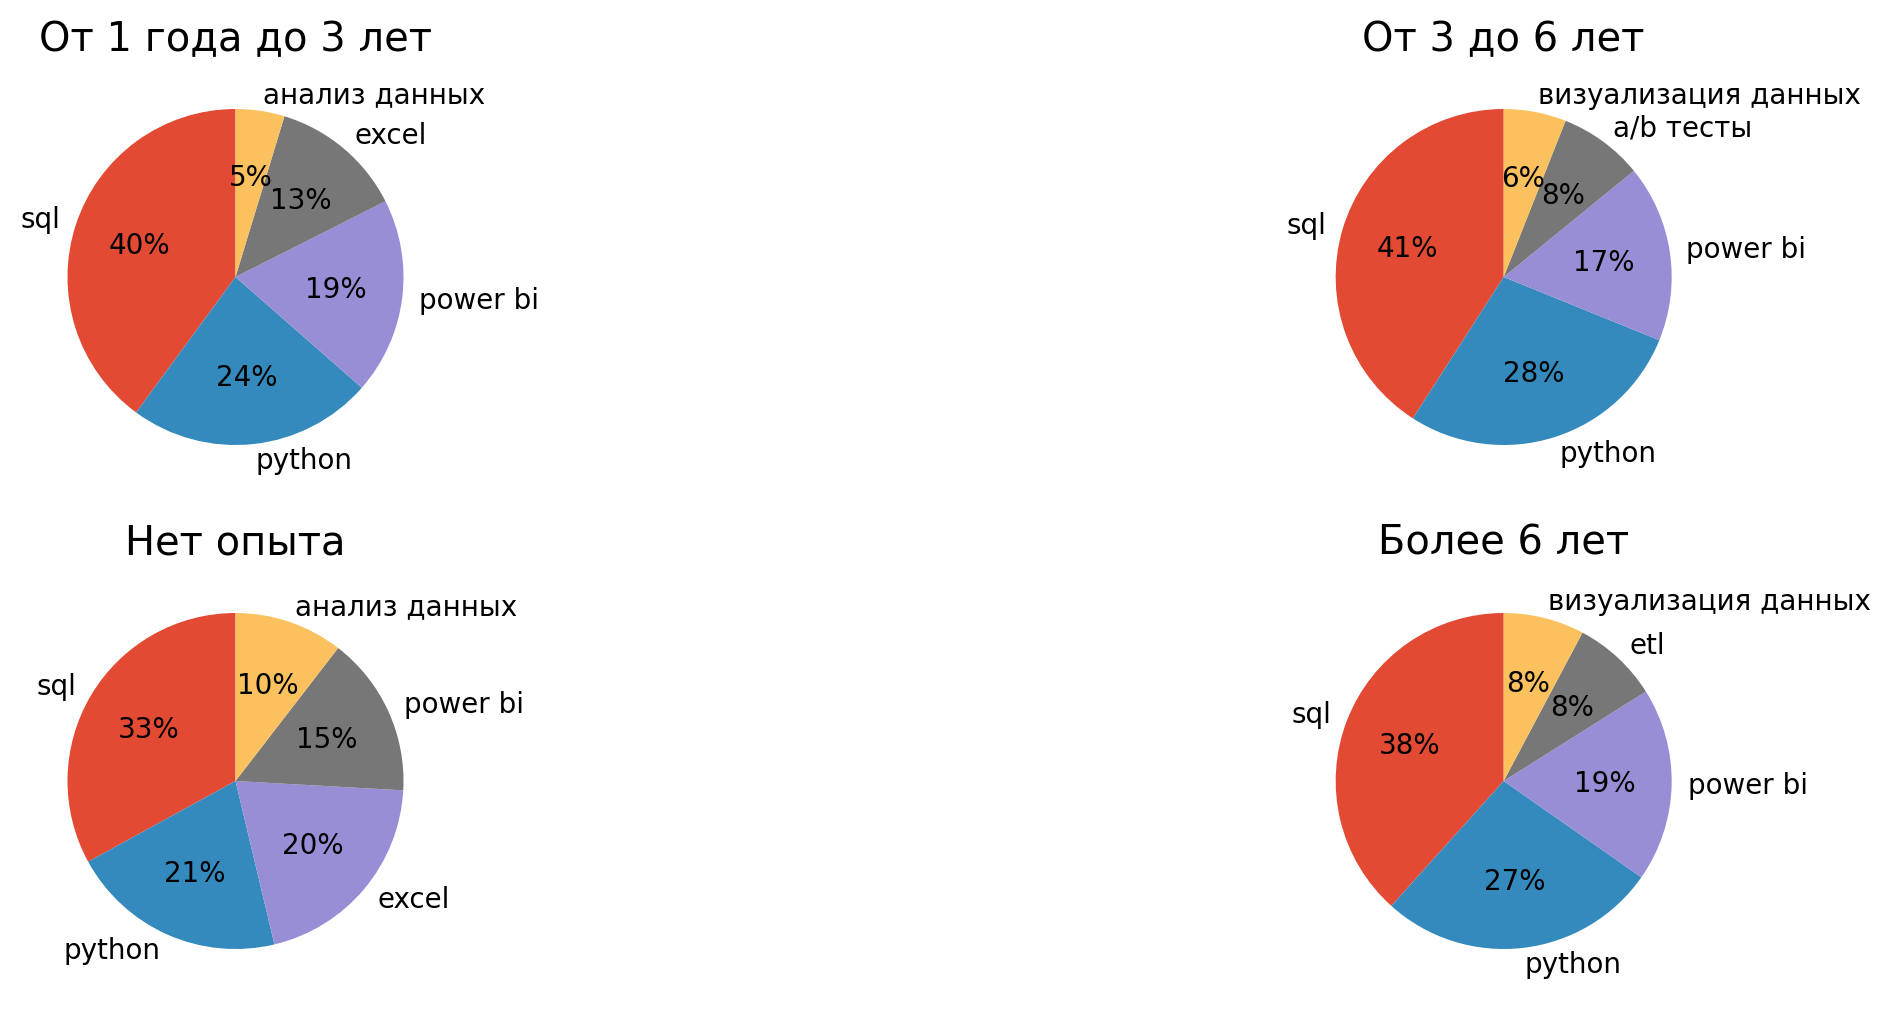

In [ ]:
# посмотрим на навыки в разрезе опыта
exp = ['От 1 года до 3 лет', 'От 3 до 6 лет', 'Нет опыта', 'Более 6 лет']
# напишем цикл для последовательного создания и вывода информации
# в виде диаграмм
for i in range(len(exp)):
  skills = (skills_count(da.query(f'experience == "{exp[i]}"')
            ['grouped_skills']).head(5))
  plt.subplot(2, 2, i+1)
  plt.pie(skills,
          labels=skills.index,
          autopct='%.0f%%',
          startangle=90)
  plt.title(f'{exp[i]}')


plt.show()

1. Из диаграмм видно, что требуемые навыки примерно везде одинаковые: sql, python, power bi. Наиболее часто фигурируют sql (от 33% для "нет опыта" до 41% "от 3 до 6 лет"), python (от 21% для "нет опыта" до 28% "от 3 до 6 лет").
2. В группах без опыта и 1 - 3 года также есть excel, причем в вакансиях без опыта его спрашивают чаще.
3. Интересно, что более опытных сотрудников больше просят визуализировать данные, а не анализировать.

Построим облако навыков, наиболее часто встречающихся в требованиях

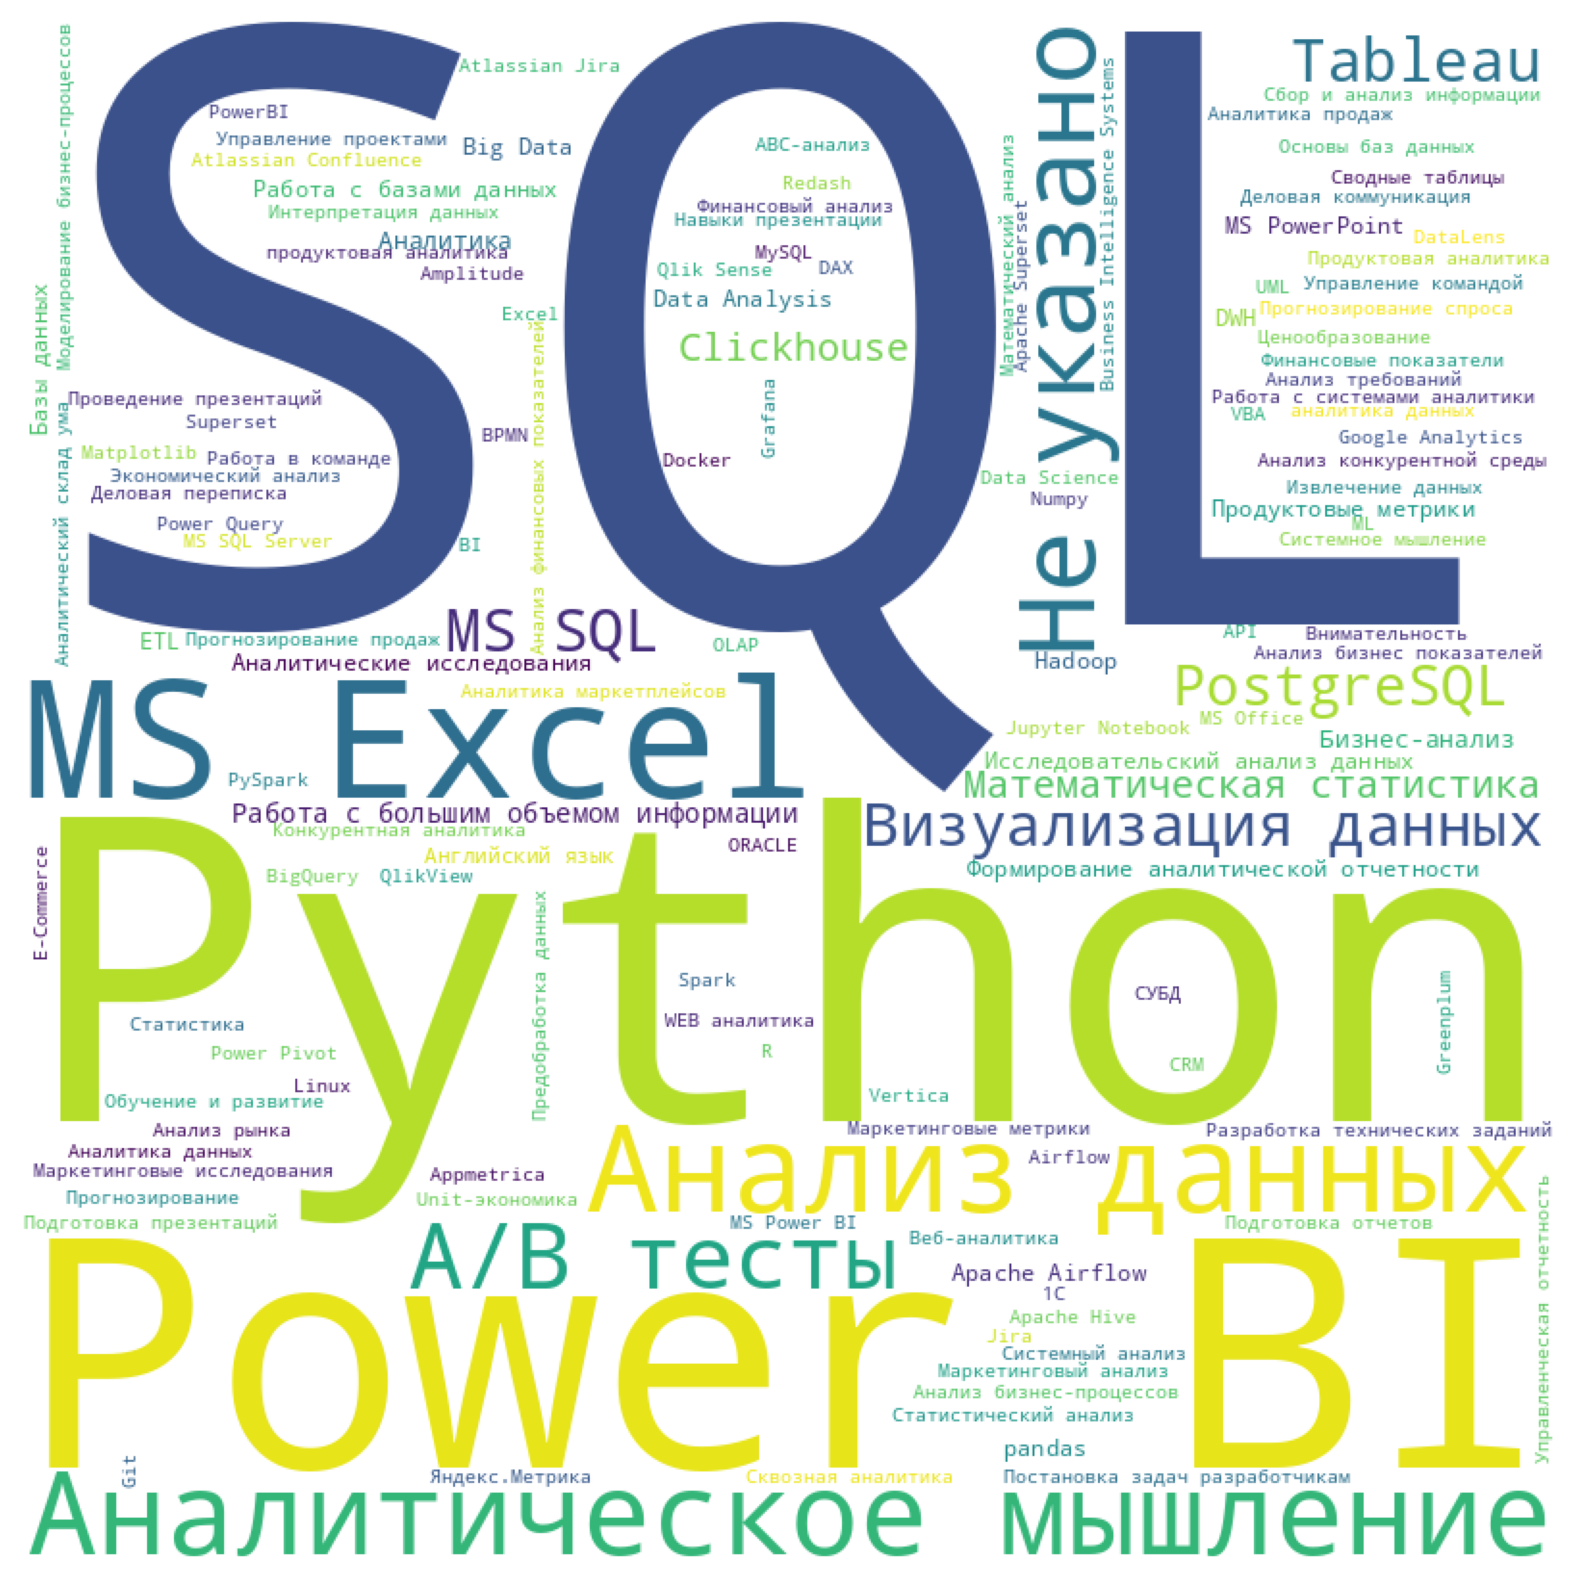

In [ ]:
# извлекаем навыки из таблицы и объединяем в один список
all_skills = [skill for sublist in da['key_skills'] for skill in sublist]

# Считаем частоту каждого навыка
skill_counts = Counter(all_skills)

# Генерируем облако слов
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800,
                      height=800,
                      stopwords=stopwords,
                      min_font_size=8,
                      background_color='white'
                     ).generate_from_frequencies(skill_counts)

# Отображаем облако слов
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Краткий вывод по навыкам:
1. Топ необходимых навыков для аналитика: SQL, Python, Power Bi, MS Excel.
2. В зависимости от опыта требования к навыкам меняется несильно. Однако, к соискателям, чей опыт небольшой чаще требуют знать Excel.
3. Также часто указывают в навыках часто указывают Аналитическое мышление и способность к анализу данных.

## Зарплаты

### Зарплаты в зависимости от опыта для дата аналитика

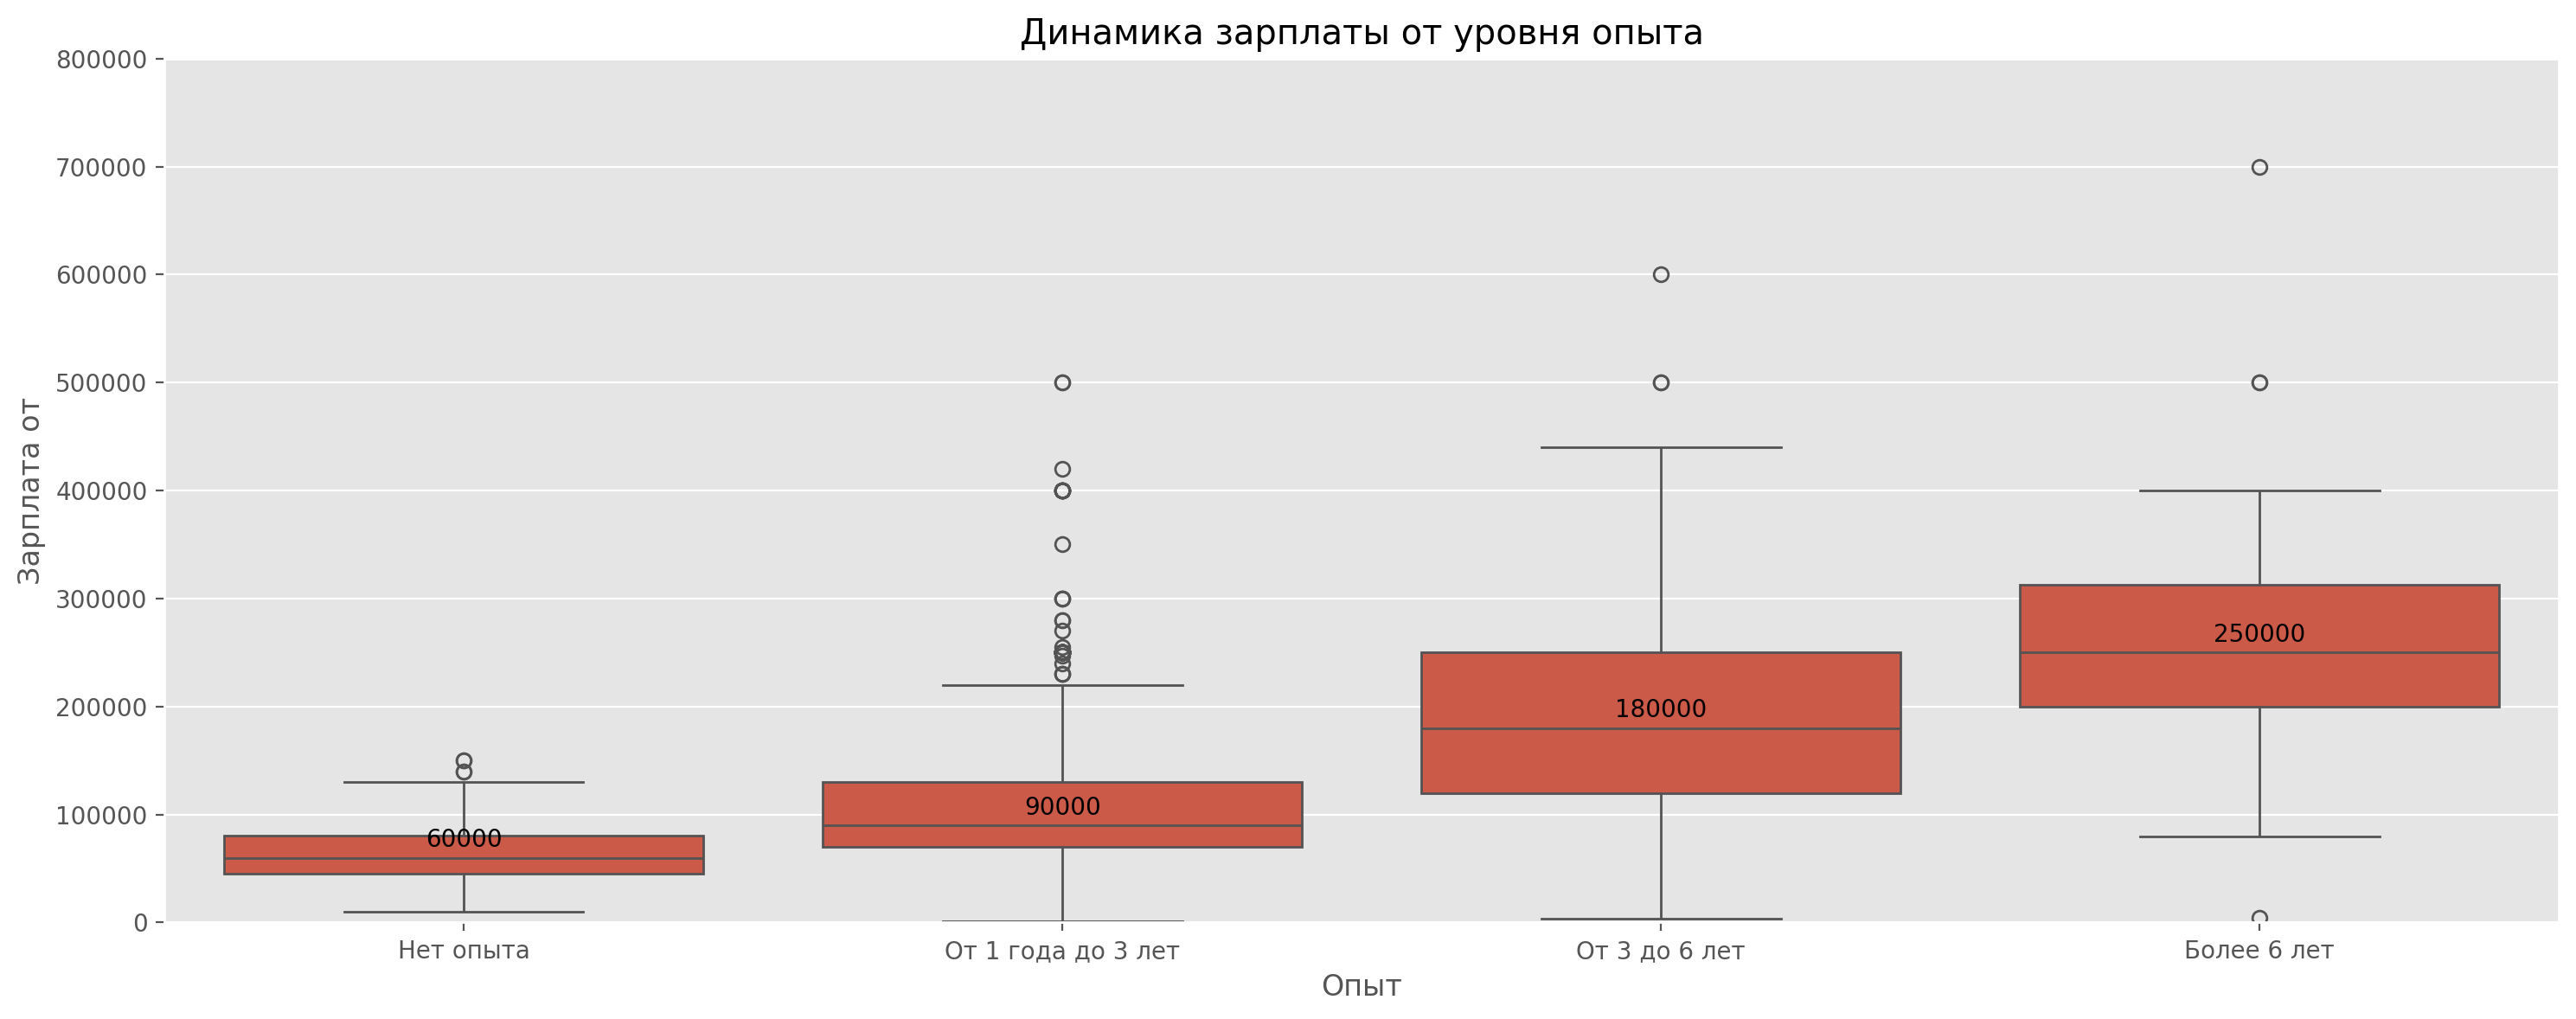

In [ ]:
# Считаем медианы зарплат по категориям опыта для сортировка
median_salary = da.groupby('experience')['salary_from'].median()
sorted_categories = median_salary.sort_values().index

# Строим график c сортировкой
sns.boxplot(x='experience', y='salary_from', data=da, order=sorted_categories)

plt.title('Динамика зарплаты от уровня опыта')
plt.ylabel('Зарплата от')
plt.xlabel('Опыт')
plt.ylim((0,800000))

# отображение медианной зарплаты на графике
for i, cat in enumerate(sorted_categories):
    median_value = median_salary[cat]
    plt.text(i, median_value + 5000, f'{median_value:.0f}', ha='center', va='bottom')


plt.tight_layout()
plt.show()

1. На графике отображены зарплаты, публикуемые в вакансиях, в зависимости от указанного опыта.
2. Медианные зарплаты в зависимости от опыта растут. Медианная  зарплата в вакансиях без опыта - 60 тыс. рублей, а с опытом более 6 лет - 250 тыс. рублей.
3. Наибольшее количество выбросов из диапазона от Q1 - 1.5 IQR до Q3 + 1.5 IQR наблюдается в требуемом опыте от 1 до 3 лет. Это можно объяснить тем, что в опыт 1-3 года попадают разные грейды, от junior до senior, поэтому зарплата сильно колеблется.

По графику boxplot видно, что хотя медианные зарплаты растут в зависимости от опыта, но наличие большого количества выбросов может говорить о неоднозначном определении грейдов вакансий. То есть, опыт не может быть 100% показателем грейда, ввиду того, что разброс от 1 до 3 лет опыта в IT индустрии может содержать разные грейды.

Проверим эту гипотезу. Сделаем кластеризацию по опыту и зарплате и посмотрим, какие кластеры мы обнаружим.

In [ ]:
# отфильтруем вакансии, в которых указана зарплата.
# отфильтруем границы от 20000 до 700000
da_filtered = (da.query('20000 < salary_from <= 700000')
                 .set_index('id')
                 .copy())

In [ ]:
# оставим только колонки с опытом (категориями) и зарплатами
exp_salary = da_filtered[['experience_cat', 'salary_from']].copy()
exp_salary.sample(5)

experience_cat  salary_from
id                                    
107150118               2   250000.000
106898022               1    52000.000
116722076               1   100000.000
118557862               2   180000.000
116861296               2    65000.000

In [ ]:
# Нормализуем данные
scaler = StandardScaler()
exp_salary_sc = scaler.fit_transform(exp_salary)

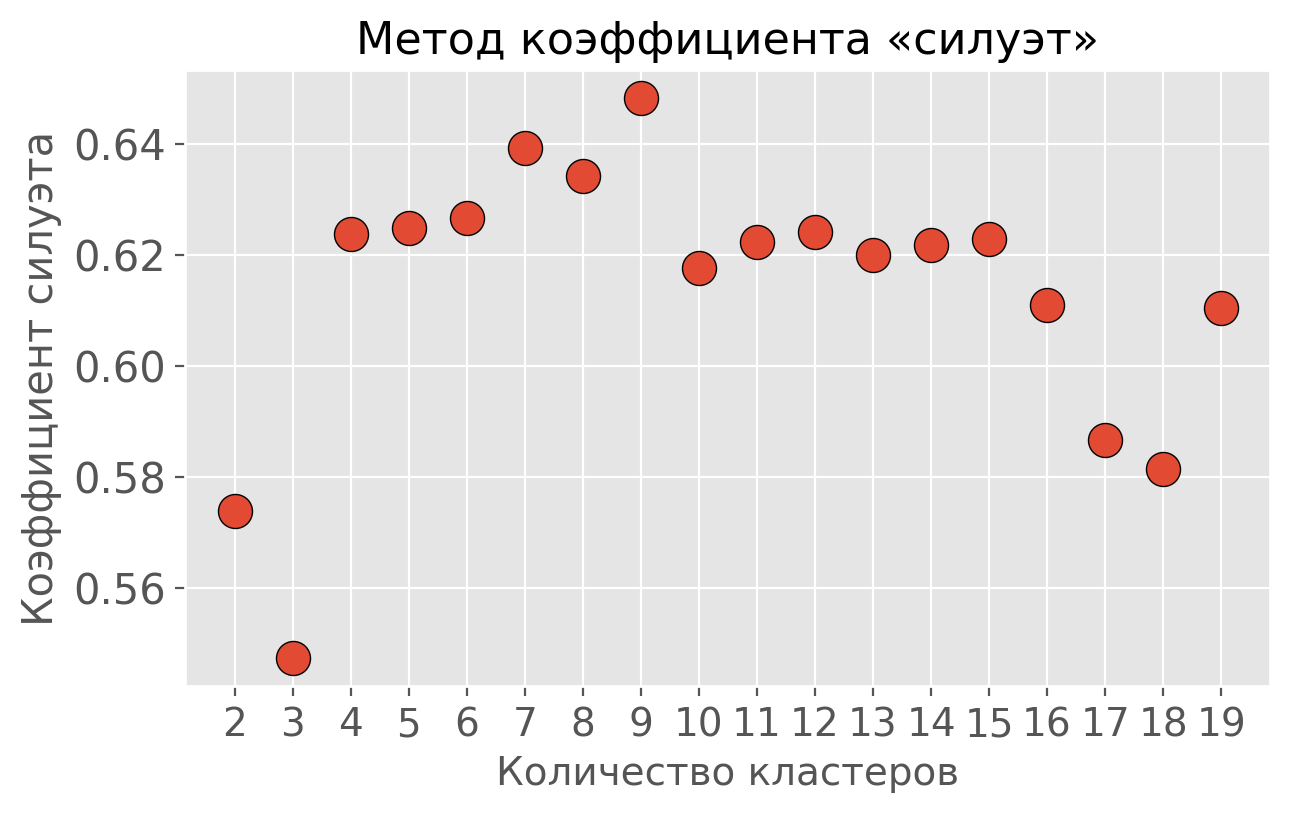

In [ ]:
# определим коэффициент силуэта
km_silhouette =[]
for i in range(2,20):
    km = KMeans(n_clusters=i, random_state=0).fit(exp_salary_sc)
    preds = km.predict(exp_salary_sc)

    silhouette = silhouette_score(exp_salary_sc,preds)
    km_silhouette.append(silhouette)

plt.figure(figsize=(7,4))
plt.title("Метод коэффициента «силуэт»", fontsize=16)
plt.scatter(x=[i for i in range(2,20)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Количество кластеров",fontsize=14)
plt.ylabel("Коэффициент силуэта",fontsize=15)
plt.xticks([i for i in range(2,20)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# Обучим модель кластеризации на основании алгоритма K-Means
km = KMeans(n_clusters = 9, random_state = 42)
y_km = km.fit_predict(exp_salary_sc)

# сохраняем метки кластера в поле нашего датасета
exp_salary['cluster_kmeans'] = y_km
# Статистика по средним значениям наших признаков по кластеру
exp_salary.groupby(['cluster_kmeans', 'experience_cat'])['salary_from'].agg(['mean', 'count', 'median', 'std'])

mean  count     median        std
cluster_kmeans experience_cat                                        
0              2              124407.680    219 120000.000  36753.997
               3               80000.000      1  80000.000        NaN
1              1              104269.485    336 100000.000  10923.814
2              0               66293.375    269  60000.000  25632.186
3              1              226553.191     94 210000.000  31207.807
4              1              420000.000     11 400000.000  40000.000
               2              403958.333     24 400000.000  57577.531
               3              500000.000      5 500000.000 122474.487
5              2              238966.180    178 250000.000  35348.029
6              1               66702.368    568  70000.000  13117.628
7              1              149039.883    223 150000.000  14035.082
8              3              237058.824     17 250000.000  56652.968

Видим, что можно сделать следующую интерпретацию данных о зарплатах и грейды:
1. Junior - 0-3 года, зарплата 40 000 – 120 000, кластеры 1, 2, 6
2. Middle - 1-6 лет, 90 000 – 180 000, кластеры 0, 7
3. Middle+ - 3-6 лет, 180 000 – 250 000, кластер 3
4. Senior - 3-6+ лет, 200 000 – 350 000, кластер 5, 8
5. Lead - 6+ лет, 350 000 – 600 000, кластер 4

# Вывод


1. **География вакансий**:  
   - 69% вакансий сосредоточено в Москве, 11% — в Санкт-Петербурге.  
   - В регионах (Новосибирск, Екатеринбург, Нижний Новгород) чаще требуются специалисты с меньшим опытом (0–3 года).  

2. **Требования к опыту**:  
   - Основной спрос — на аналитиков с 1–3 годами опыта (55% вакансий).  
   - Крупные компании (Яндекс, СБЕР, Озон, ВТБ) формируют основной спрос:  
     - Яндекс чаще нанимает опытных (3–6 лет, 83,9%).  
     - СБЕР, Озон, ВТБ чаще берут с 1–3 годами опыта.  
     - ВТБ и СБЕР чаще других рассматривают кандидатов без опыта.  

3. **Навыки**:  
   - Топ-навыки: SQL (33–41%), Python (21–28%), Power BI, Excel.  
   - Без опыта чаще требуют Excel.  
   - Опытные чаще работают с визуализацией данных.  

4. **Зарплаты и грейды**:  
   - Медианные зарплаты растут с опытом:  
     - Без опыта: 60 тыс. руб.  
     - 1–3 года: от 40 до 180 тыс. руб.  
     - 3–6 лет: 180–250 тыс. руб.  
     - 6+ лет: 250–600 тыс. руб.  
   - **Кластеризация зарплат** показывает, что опыт не равно грейд:  
     - Junior (0–3 года): 40–120 тыс. руб.  
     - Middle (1–6 лет): 90–180 тыс. руб.  
     - Senior (3–6+ лет): 200–350 тыс. руб.  
     - Lead (6+ лет): 350–600 тыс. руб.  

5. **Динамика публикаций**:  
   - Пик активности — 10–11 утра по будням, особенно по понедельникам.  
   - Сезонные всплески: май, сентябрь–октябрь, спад — июль–август.  

---  

### **Рекомендации**  

*Для HR и работодателей*:  
- Уточняйте грейды в вакансиях (не только опыт, но и уровень). Опыт 1–3 года может означать как Junior, так и Middle, что создает путаницу в зарплатных ожиданиях.  
  

*Для соискателей*:  
- Junior: упор на SQL, Python, Excel.  
- Middle/Senior: углубленное знание визуализации (Power BI, Tableau).  
- Опыт не равно грейд: с 1–3 годами можно претендовать на Middle и Middle+, если навыки соответствуют.  

# Часть 2: причина смены работы

Для этой части вакансии брались из API hh.ru, где в качестве фильтров указывались научные сотрудники. Также был осуществлен парсинг специализированного сайта, в котором выкладываются вакансии [научных сотрудников](https://ученые-исследователи.рф/).

## Данные сайта ученые-исследователи

### Загрузка и предобработка данных

In [ ]:
# датасет с сайта ученые-исследователи
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/вакансии_ученые-исследователи_2024-2025.csv', index_col=0)

In [ ]:
df.head()

id                                           employer  \
0   VAC_133358   Федеральное государственное автономное образо...   
1   VAC_133356   Федеральное государственное бюджетное образов...   
2   VAC_133355   Федеральное государственное бюджетное учрежде...   
3   VAC_133354   Федеральное государственное бюджетное учрежде...   
4   VAC_133348   Федеральное государственное бюджетное учрежде...   

                                                name              area  \
0   Директор (заведующий, начальник) отделения (и...   Санкт-Петербург   
1   Старший научный сотрудник кандидат наук Научн...            Москва   
2   Научный сотрудник Научный сотрудник лаборатор...             Томск   
3   Младший научный сотрудник/инженер-исследователь        Владивосток   
4                         Старший научный сотрудник             Москва   

   salary_from  
0       121000  
1        83135  
2        22435  
3        41169  
4        33865

In [ ]:
# проверим на дубликаты
df.duplicated().sum()

np.int64(51)

In [ ]:
# удалим дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

Явные дубликаты удалили, но из-за особенностей выкладывания вакансий на сайте есть неявные дубликаты, а именно - одинаковые по всем показателям названия вакансий отличаются только по id

In [ ]:
df.duplicated(subset=['name', 'employer', 'area', 'salary_from']).sum()

np.int64(751)

In [ ]:
df = df.drop_duplicates(subset=['name', 'employer', 'area', 'salary_from'])
df.duplicated(subset=['name', 'employer', 'area', 'salary_from']).sum()

np.int64(0)

Был 751 дубликат. Мы их удалили. Эти дубликаты появляются из-за того, что открываются абсолютно одинаковые ставки, например научного сотрудника. Нет смысла их как-то различать, так как часто открываются они массово один раз в год и все сотрудники учреждения поступают на каждый свою ставку. Также ставка часто открывается под конкретного человека, иначе устроиться в научное учреждение нельзя.

### Анализ зарплат

In [ ]:
df['salary_from'].describe()

count       1975.000
mean       70345.892
std      1056529.147
min          729.000
25%        27445.000
50%        34338.000
75%        41778.500
max     34999000.000
Name: salary_from, dtype: float64

есть какая-то ошибка в максимальной зарплате. Судя по всему, кто-то ошибся на три ноля.

In [ ]:
# отсортируем и увидим, последние значения
df['salary_from'].sort_values()

122         729
129        1194
446        2062
235        2300
259        2300
         ...   
69       250000
85       271000
327      355809
732    31380000
89     34999000
Name: salary_from, Length: 1975, dtype: int64

In [ ]:
# отфильтруем вакансии с зп боле 250000
df.query('salary_from >= 250000')

id                                           employer  \
85    VAC_135617   Федеральное государственное бюджетное учрежде...   
89    VAC_135607   Федеральное государственное бюджетное учрежде...   
69    VAC_138290   Федеральное государственное автономное образо...   
327   VAC_137772   Федеральное государственное бюджетное учрежде...   
732   VAC_128882   Федеральное государственное бюджетное учрежде...   

                                                  name           area  \
85    Научный сотрудник лаборатории эволюционной эк...    Архангельск   
89    Старший научный сотрудник Лаборатории экологи...         Москва   
69    Научный сотрудник лаборатории фотонных газовы...         Москва   
327   Директор (заведующий, начальник) отделения (и...         Москва   
732                         Старший научный сотрудник    Екатеринбург   

     salary_from  
85        271000  
89      34999000  
69        250000  
327       355809  
732     31380000

In [ ]:
for i in df.query('salary_from >= 250000').index:
  display(df.query('salary_from >= 250000').loc[i, 'name'])

' Научный сотрудник лаборатории эволюционной экологии и геномики гидробионтов (1.0 ставка) '

' Старший научный сотрудник Лаборатории экологии водных сообществ и инвазий '

' Научный сотрудник лаборатории фотонных газовых сенсоров '

' Директор (заведующий, начальник) отделения (института, центра), находящегося в структуре организации РУКОВОДИТЕЛЬ управления биомедицинских технологий '

' Старший научный сотрудник '

Исходя из названий могу сделать вывод, что вакансии VAC_135617, VAC_135607, VAC_128882, явно заполнены с ошибкой. Либо сознательно, чтобы завысить метрики на сайте. Исправим это.

In [ ]:
df.at[85, 'salary_from'] = 27100
df.at[89, 'salary_from'] = 34999
df.at[732, 'salary_from'] = 31380
df['salary_from'].describe()

count     1975.000
mean     36590.337
std      21281.787
min        729.000
25%      27445.000
50%      34300.000
75%      41580.000
max     355809.000
Name: salary_from, dtype: float64

Выбросы сверху убрали. Посмотрим минимальное значение.

In [ ]:
display(df.query('salary_from <= 2000'))
print('---')
display(df.query('salary_from <= 1000').loc[122, 'name'])
display(df.query('salary_from <= 1000').loc[122, 'employer'])

id                                           employer  \
122   VAC_135548   федеральное государственное бюджетное учрежде...   
129   VAC_135535   федеральное государственное бюджетное учрежде...   

                                                  name              area  \
122   Научный сотрудник Лаборатория химиотерапии ви...   Санкт-Петербург   
129     Ведущий научный сотрудник Отдел биотехнологии    Санкт-Петербург   

     salary_from  
122          729  
129         1194

---


' Научный сотрудник Лаборатория химиотерапии вирусных инфекций '

' федеральное государственное бюджетное учреждение "Научно-исследовательский институт гриппа имени А.А. Смородинцева" Министерства здравоохранения Российской Федерации '

Значение зарплаты очень низкое. Возможно, это 0.01 ставки, но в описании не написано. Буду считать, что это реальные зарплаты, потому что, так просто на сайт не выставляют вакансию.

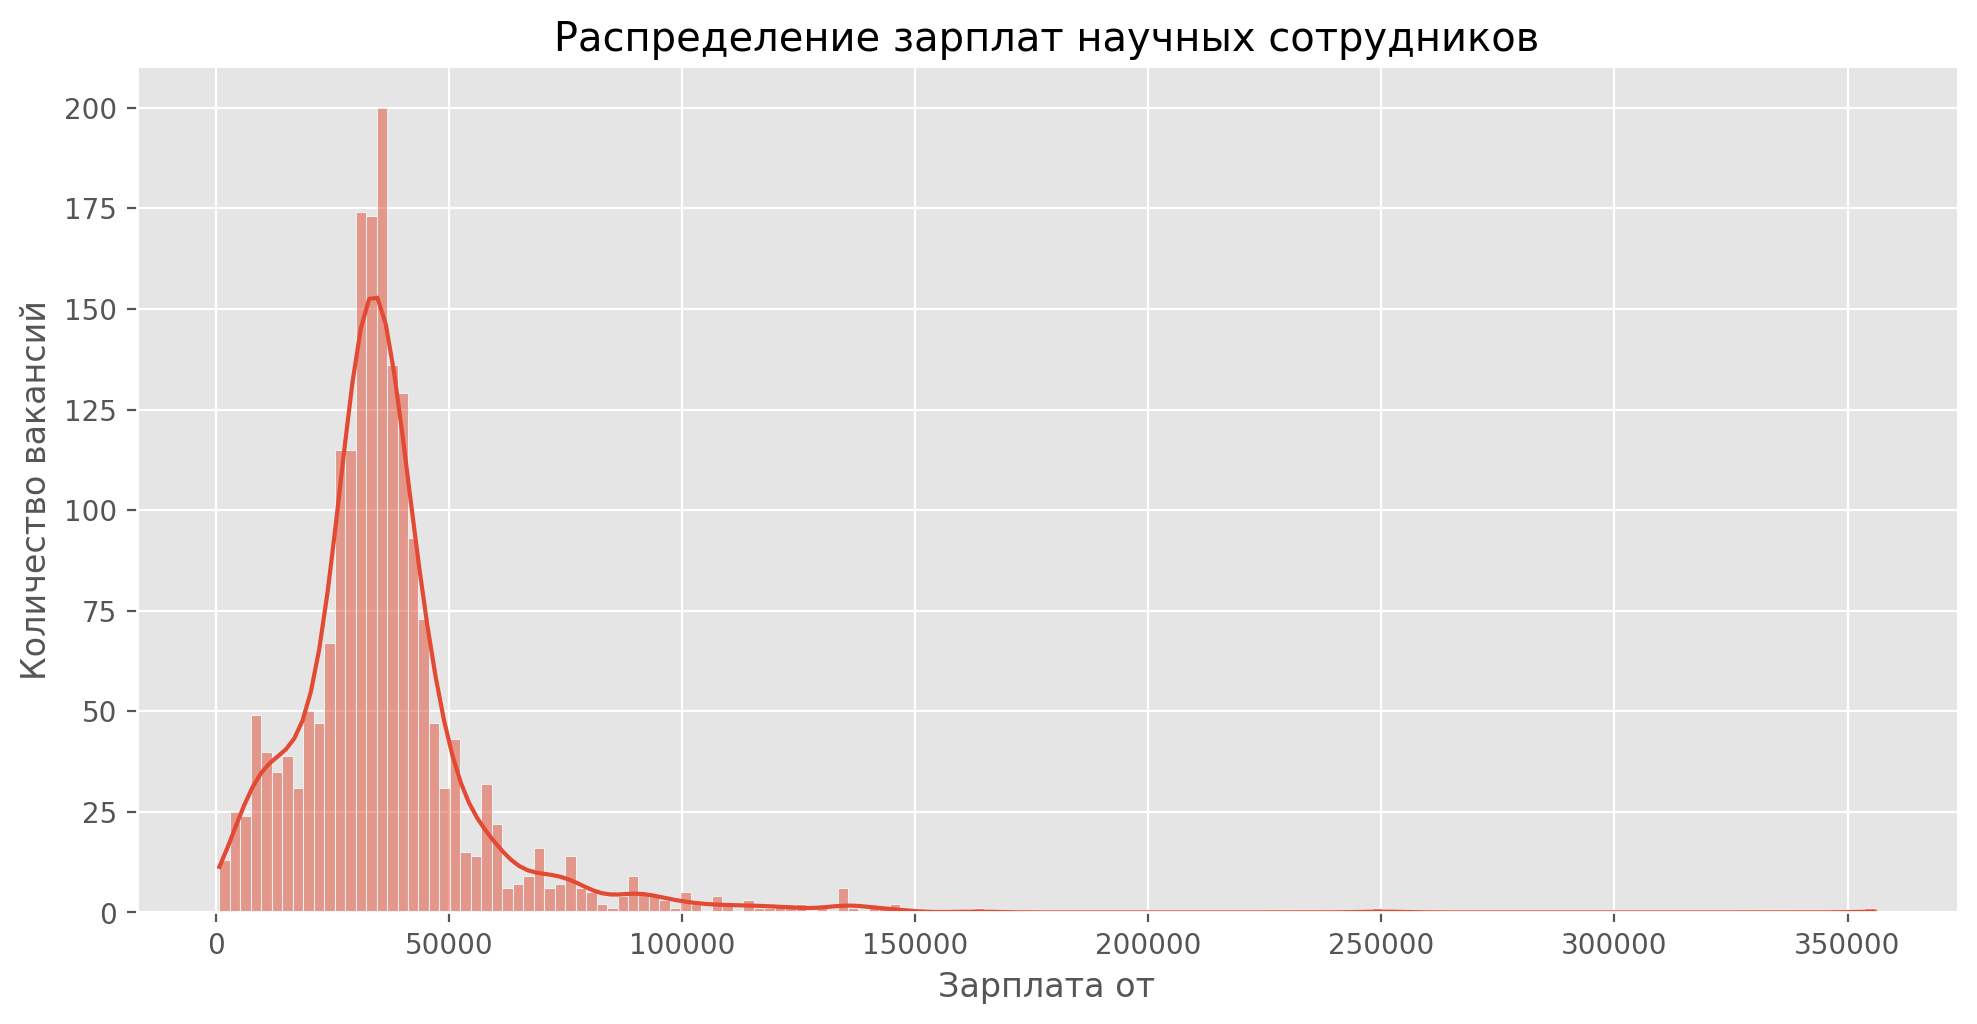

In [ ]:
sns.displot(df['salary_from'], kde=True, aspect=2)

plt.title('Распределение зарплат научных сотрудников')
plt.ylabel('Количество вакансий')
plt.xlabel('Зарплата от')
plt.show()

Как видно, большенство зарплат сосредоточены в районе до 100 тыс.

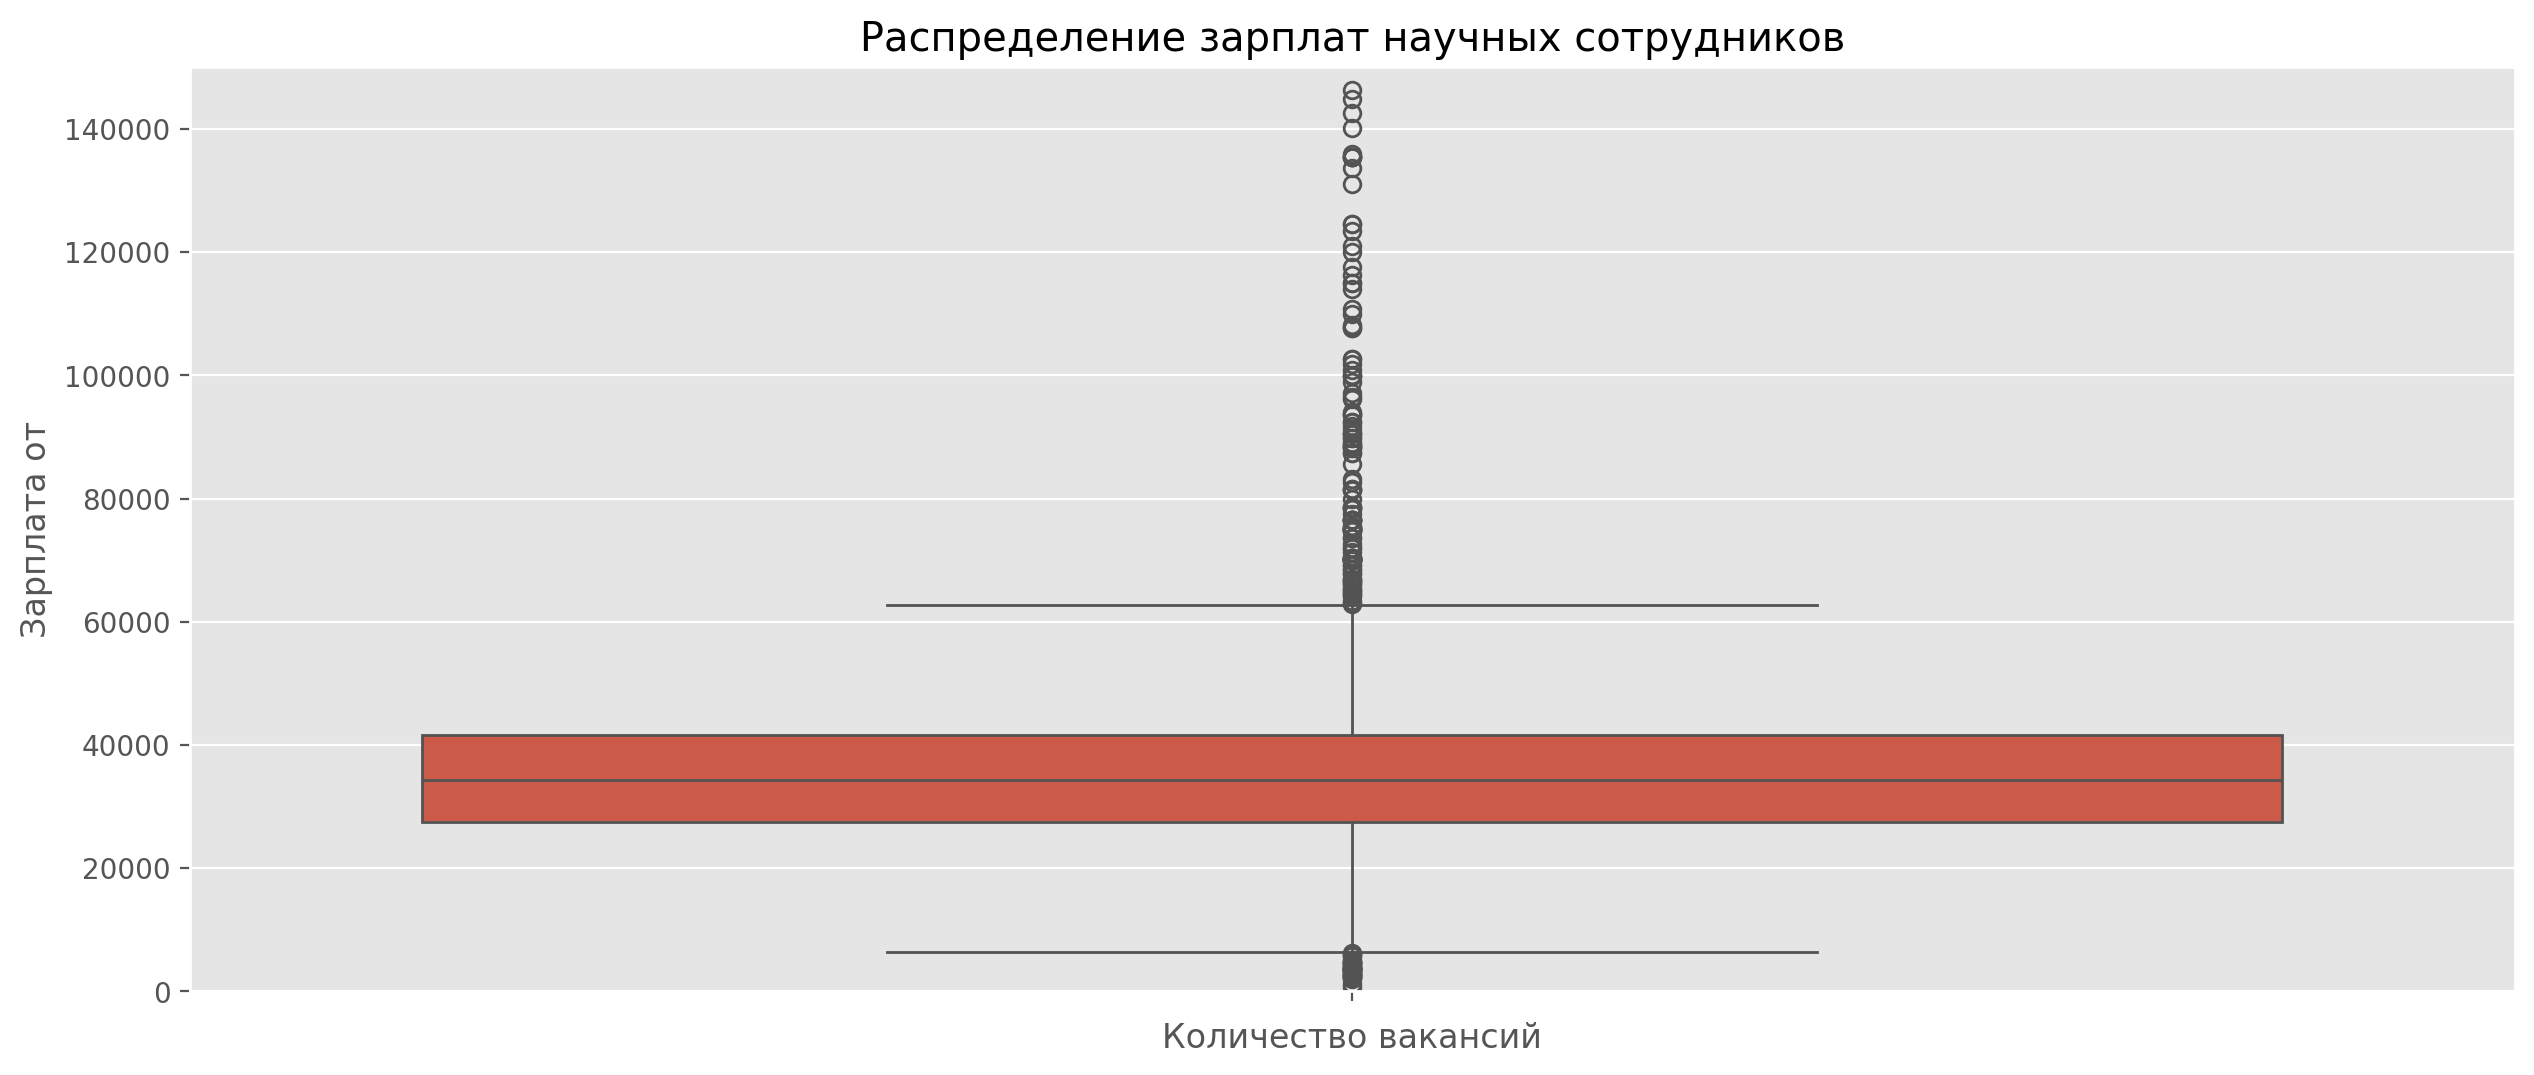

In [ ]:
# построим boxplot для наглядности
sns.boxplot(df['salary_from'])

plt.ylim(0, 150000)
plt.title('Распределение зарплат научных сотрудников')
plt.ylabel('Зарплата от')
plt.xlabel('Количество вакансий')
plt.show()

как видно, основное количество зарплат лежит в диапазоне от 10000 до 62000 рублей.

In [ ]:
df['name'].value_counts()

name
Научный сотрудник                                                                                                                                            148
Старший научный сотрудник                                                                                                                                    142
Ведущий научный сотрудник                                                                                                                                     92
Младший научный сотрудник/инженер-исследователь                                                                                                               54
Заведующий (начальник) научно-исследовательского отдела (лаборатории)                                                                                         41
                                                                                                                                                            ... 
Научный сотрудник лаборатории физической химии конденсированных сред                                                                                           1
Научный сотрудник Лаборатория синтеза кластерных соединений и материалов                                                                                       1
Младший научный сотрудник/инженер-исследователь лаборатории энтомологии                                                                                        1
Младший научный сотрудник/инженер-исследователь НИЛ наноструктурированных сегнетоэлектрических материалов ФГБОУ ВО "Курский государственный университет"       1
Младший научный сотрудник/инженер-исследователь Лаборатория демографии и социального управления                                                                1
Name: count, Length: 1400, dtype: int64

In [ ]:
# выделим из названия должности научного сотрудника
# Правила для основных должностей
patterns = [
    (r'Научный сотрудник', 'Научный сотрудник'),
    (r'Старший научный сотрудник', 'Старший научный сотрудник'),
    (r'Ведущий научный сотрудник', 'Ведущий научный сотрудник'),
    (r'Младший научный сотрудник', 'Младший научный сотрудник'),
    (r'Заведующий.*лаборатори\w*', 'Заведующий лаборатории'),
    (r'Директор', 'Директор')
]

def extract_title(row):
    for pattern, title in patterns:
        if re.search(pattern, row['name']):
            return title
    return 'Другое'

df['name_title'] = df.apply(extract_title, axis=1)

df['name_title'].value_counts()

name_title
Старший научный сотрудник    599
Научный сотрудник            588
Ведущий научный сотрудник    300
Младший научный сотрудник    181
Заведующий лаборатории       178
Другое                       100
Директор                      29
Name: count, dtype: int64

In [ ]:
# построим график распределения медианной зарплаты в зависимости от должности
salary_grouped = (df.groupby('name_title', as_index=False)['salary_from']
                    .agg(['mean', 'median', 'std'])
                    .sort_values(by='median'))

salary_grouped

name_title      mean    median       std
4  Младший научный сотрудник 24100.801 27100.000  9538.221
5          Научный сотрудник 32682.301 31482.000 15741.012
6  Старший научный сотрудник 36854.050 35000.000 15053.924
0  Ведущий научный сотрудник 39126.717 38890.000 20795.218
3     Заведующий лаборатории 39514.775 43014.000 24602.606
2                     Другое 54759.640 44136.500 34020.020
1                   Директор 81492.862 63330.000 63669.142

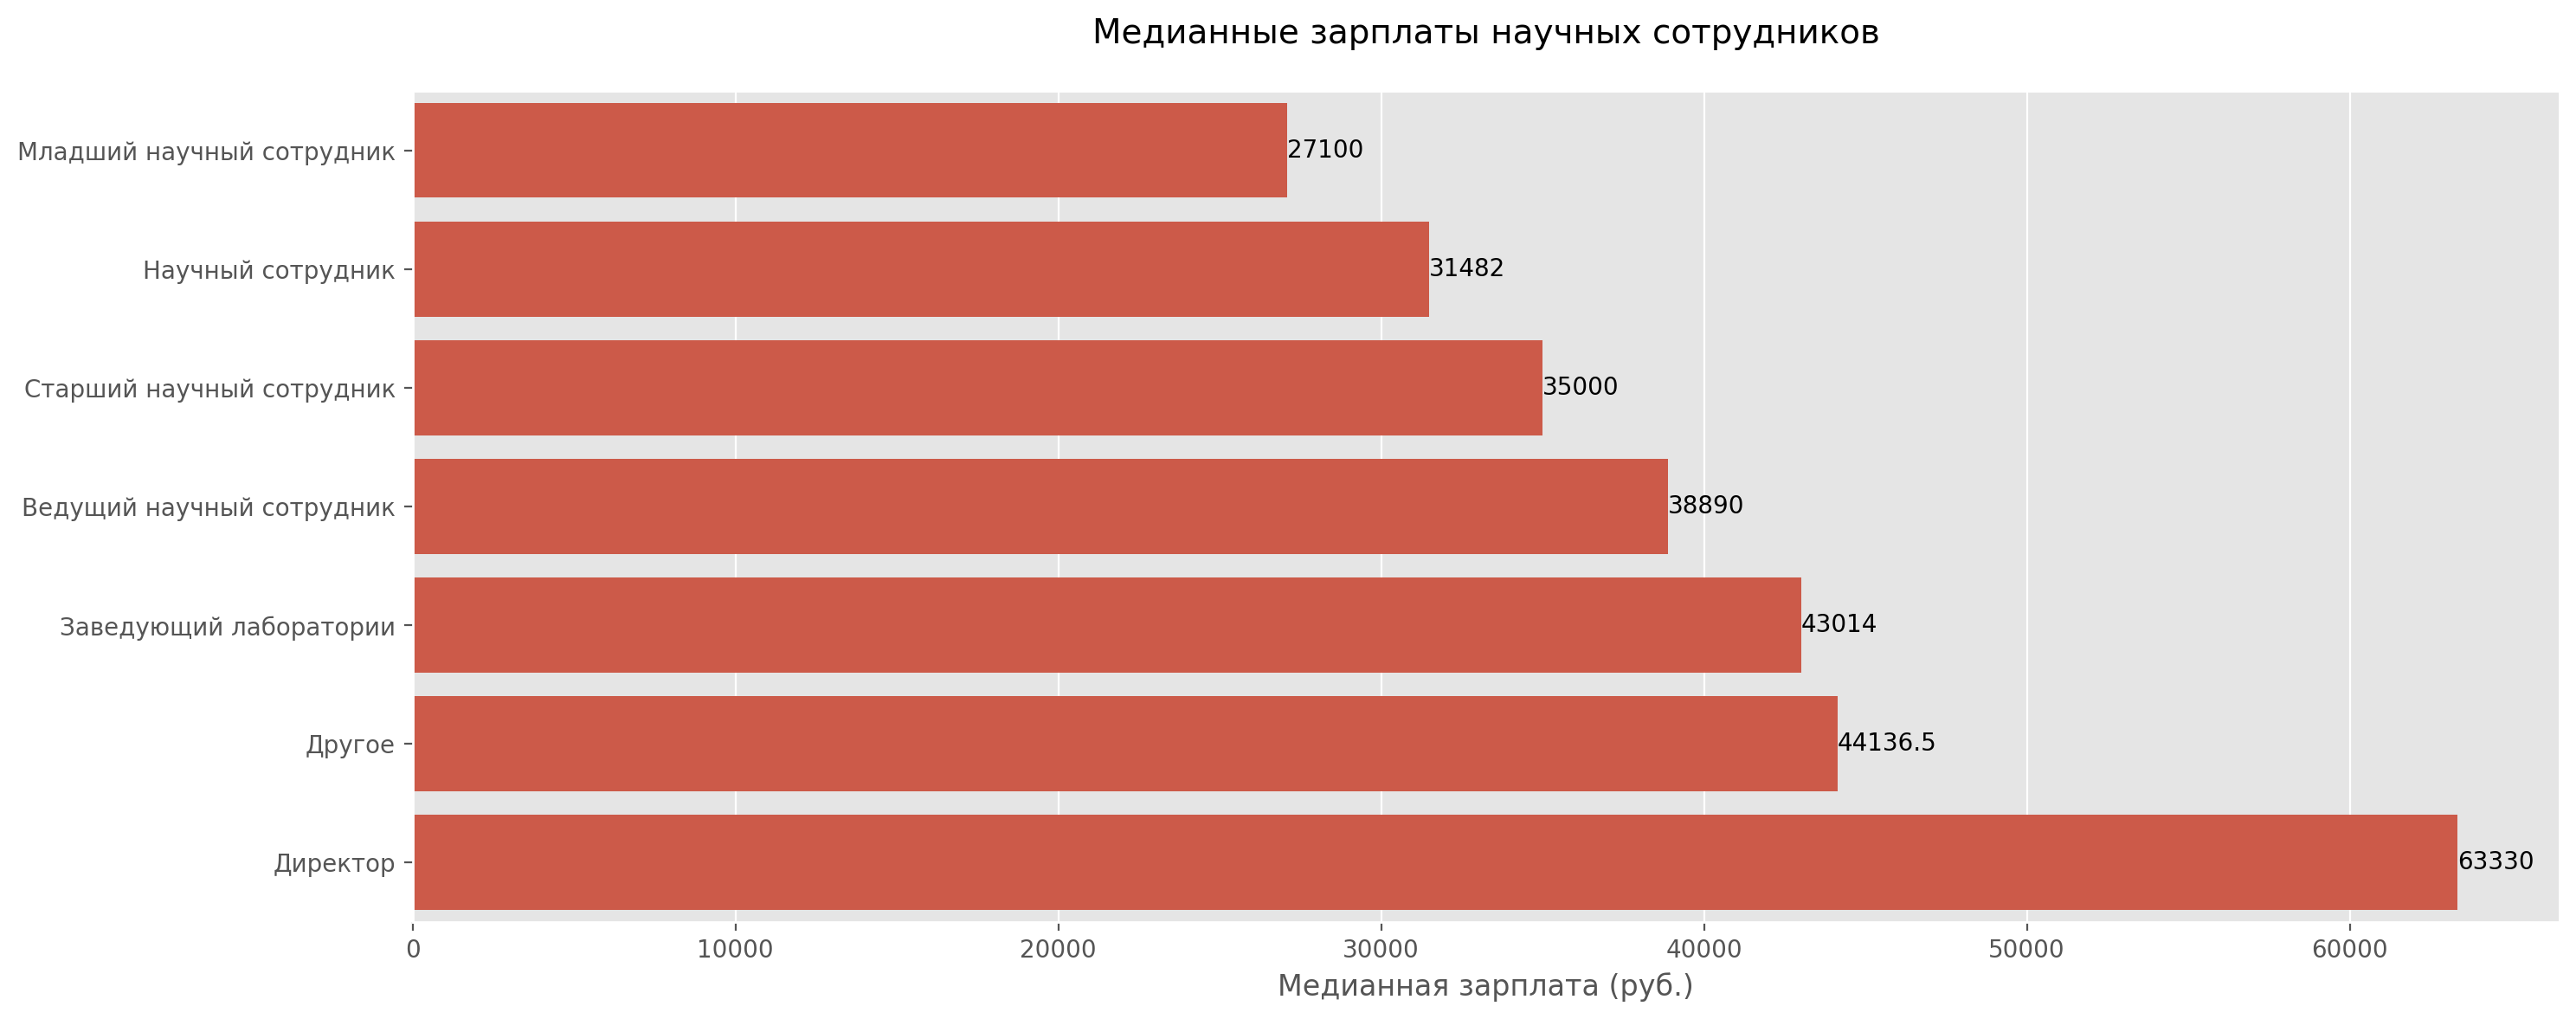

In [ ]:
ax = sns.barplot(
    x='median',
    y='name_title',
    data=salary_grouped
)
ax.bar_label(ax.containers[0])
plt.title('Медианные зарплаты научных сотрудников', fontsize=14, pad=20)
plt.xlabel('Медианная зарплата (руб.)', fontsize=12)
plt.ylabel('')

plt.tight_layout()
plt.show()

- Как видно, медианные зарплаты научных сотрудников варьируются от 27 000 до 40 000 рублей.
- Да, это оклады. К ним добавляются премии, которые иногда достигают 100% от оклада. Получается, что реальная зарплата научных сотрудников может быть в два раза выше оклада.
- Также существуют гранты, но их получают не все. В условиях грантов указано, что они могут выполняться не только в рабочее, но и во внерабочее время. То есть, это своего рода подработка.
- Важно отметить, что это касается не всех научных сотрудников и не всех организаций. В некоторых лабораториях зарплаты высокие и стабильные, и там всегда есть гранты. Но есть и статистическая шутка: «Одни едят мясо, другие — капусту. В среднем все едят голубцы».

## Вакансии научных сотрудников из HH.ru

### Загрузка и предобработка данных

Посмотрим на вакансии исследовательй из HH.ru. Скачивание вакансий проводилось в течение полугода.

In [ ]:
df_hh_researches = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hh_researchers2024-2025.csv', index_col=0)
df_hh_researches.head()

id                                       vacancy_name     schedule  \
0  109150277                                  Научный сотрудник  Полный день   
1  109164358                          Старший научный сотрудник  Полный день   
2  109484393  Научный сотрудник (Физико-Химическое направление)  Полный день   
3  109294427                                  Научный сотрудник  Полный день   
4  108831201        Младший научный сотрудник (м. Чернышевская)  Полный день   

           experience             city                     employer  \
0  От 1 года до 3 лет           Москва                Марлин Биотех   
1       От 3 до 6 лет           Москва                         МФТИ   
2  От 1 года до 3 лет           Москва  Материа Медика Холдинг, НПФ   
3  От 1 года до 3 лет           Москва                        Базон   
4           Нет опыта  Санкт-Петербург                   Staffberry   

   salary_from  salary_to      type                              url  \
0   100000.000        NaN  Открытая  https://hh.ru/vacancy/109150277   
1   180000.000 300000.000  Открытая  https://hh.ru/vacancy/109164358   
2          NaN        NaN  Открытая  https://hh.ru/vacancy/109484393   
3   100000.000        NaN  Открытая  https://hh.ru/vacancy/109294427   
4    80000.000 100000.000  Открытая  https://hh.ru/vacancy/108831201   

                                          key_skills  \
0  ['ПЦР-метод', 'Биологические исследования', 'В...   
1                                                 []   
2  ['Английский язык', 'MS PowerPoint', 'Аналитич...   
3                                                 []   
4  ['Компас 3Д', 'SolidWorks', 'Python', 'Разрабо...   

                                   professional_role  
0  [{'id': '79', 'name': 'Научный специалист, исс...  
1  [{'id': '79', 'name': 'Научный специалист, исс...  
2  [{'id': '79', 'name': 'Научный специалист, исс...  
3  [{'id': '79', 'name': 'Научный специалист, исс...  
4  [{'id': '79', 'name': 'Научный специалист, исс...

In [ ]:
# проверка на дубликаты
df_hh_researches.duplicated().sum()

np.int64(506)

In [ ]:
# удаление дубликатов
df_hh_researches = df_hh_researches.drop_duplicates()
df_hh_researches.duplicated().sum()
df_hh_researches = df_hh_researches.reset_index(drop=True)

In [ ]:
df_hh_researches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1094 non-null   int64  
 1   vacancy_name       1094 non-null   object 
 2   schedule           1094 non-null   object 
 3   experience         1094 non-null   object 
 4   city               1094 non-null   object 
 5   employer           1094 non-null   object 
 6   salary_from        489 non-null    float64
 7   salary_to          254 non-null    float64
 8   type               1094 non-null   object 
 9   url                1094 non-null   object 
 10  key_skills         691 non-null    object 
 11  professional_role  1094 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 102.7+ KB


За полгода есть только 1000 вакансий, причем это всех вакасний всех профилей, где фигуировало название научный сотрудник.
из 1000 вакансий зарплаты указаны у 489 = почти 50%, что выше, чем у дата аналитиков почти вдвое.

### Анализ зарплат

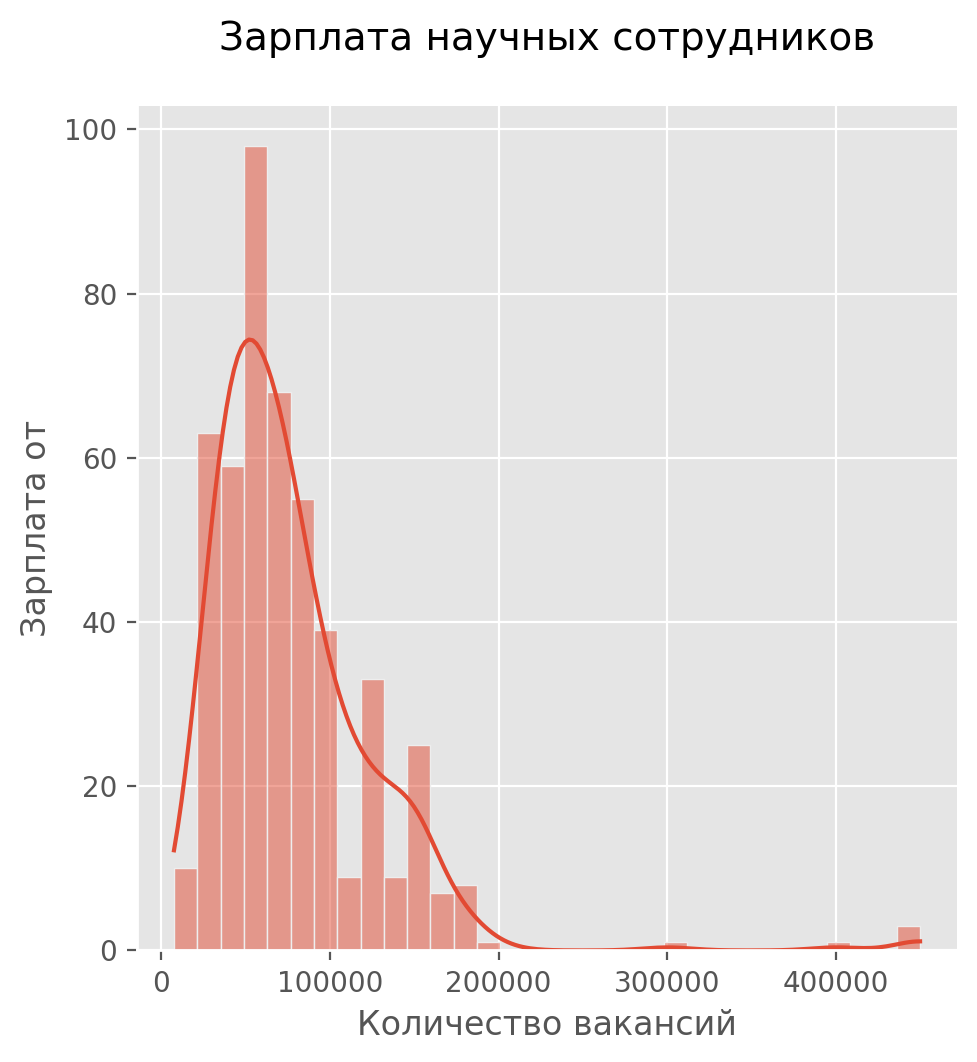

count      489.000
mean     77941.108
std      51605.175
min       7500.000
25%      45000.000
50%      70000.000
75%     100000.000
max     450000.000
Name: salary_from, dtype: float64

In [ ]:
# построение гистограммы
sns.displot(df_hh_researches['salary_from'],
            kde=True)

plt.title('Зарплата научных сотрудников', fontsize=14, pad=20)
plt.xlabel('Количество вакансий')
plt.ylabel('Зарплата от')
plt.show()

df_hh_researches['salary_from'].describe()

Видим, что пик зарплат находится в районе 70 тыс. руб., там же, где и медиана.

In [ ]:
# зависимость зарплаты от опыта
salary_exp_researches = (df_hh_researches.groupby('experience', as_index=False)['salary_from']
                                         .agg(['mean', 'median', 'std']))
salary_exp_researches

experience       mean    median       std
0         Более 6 лет 101432.500 83500.000 68041.007
1           Нет опыта  47575.576 42000.000 20610.004
2  От 1 года до 3 лет  67610.756 60000.000 34922.808
3       От 3 до 6 лет 105746.027 90000.000 62789.114

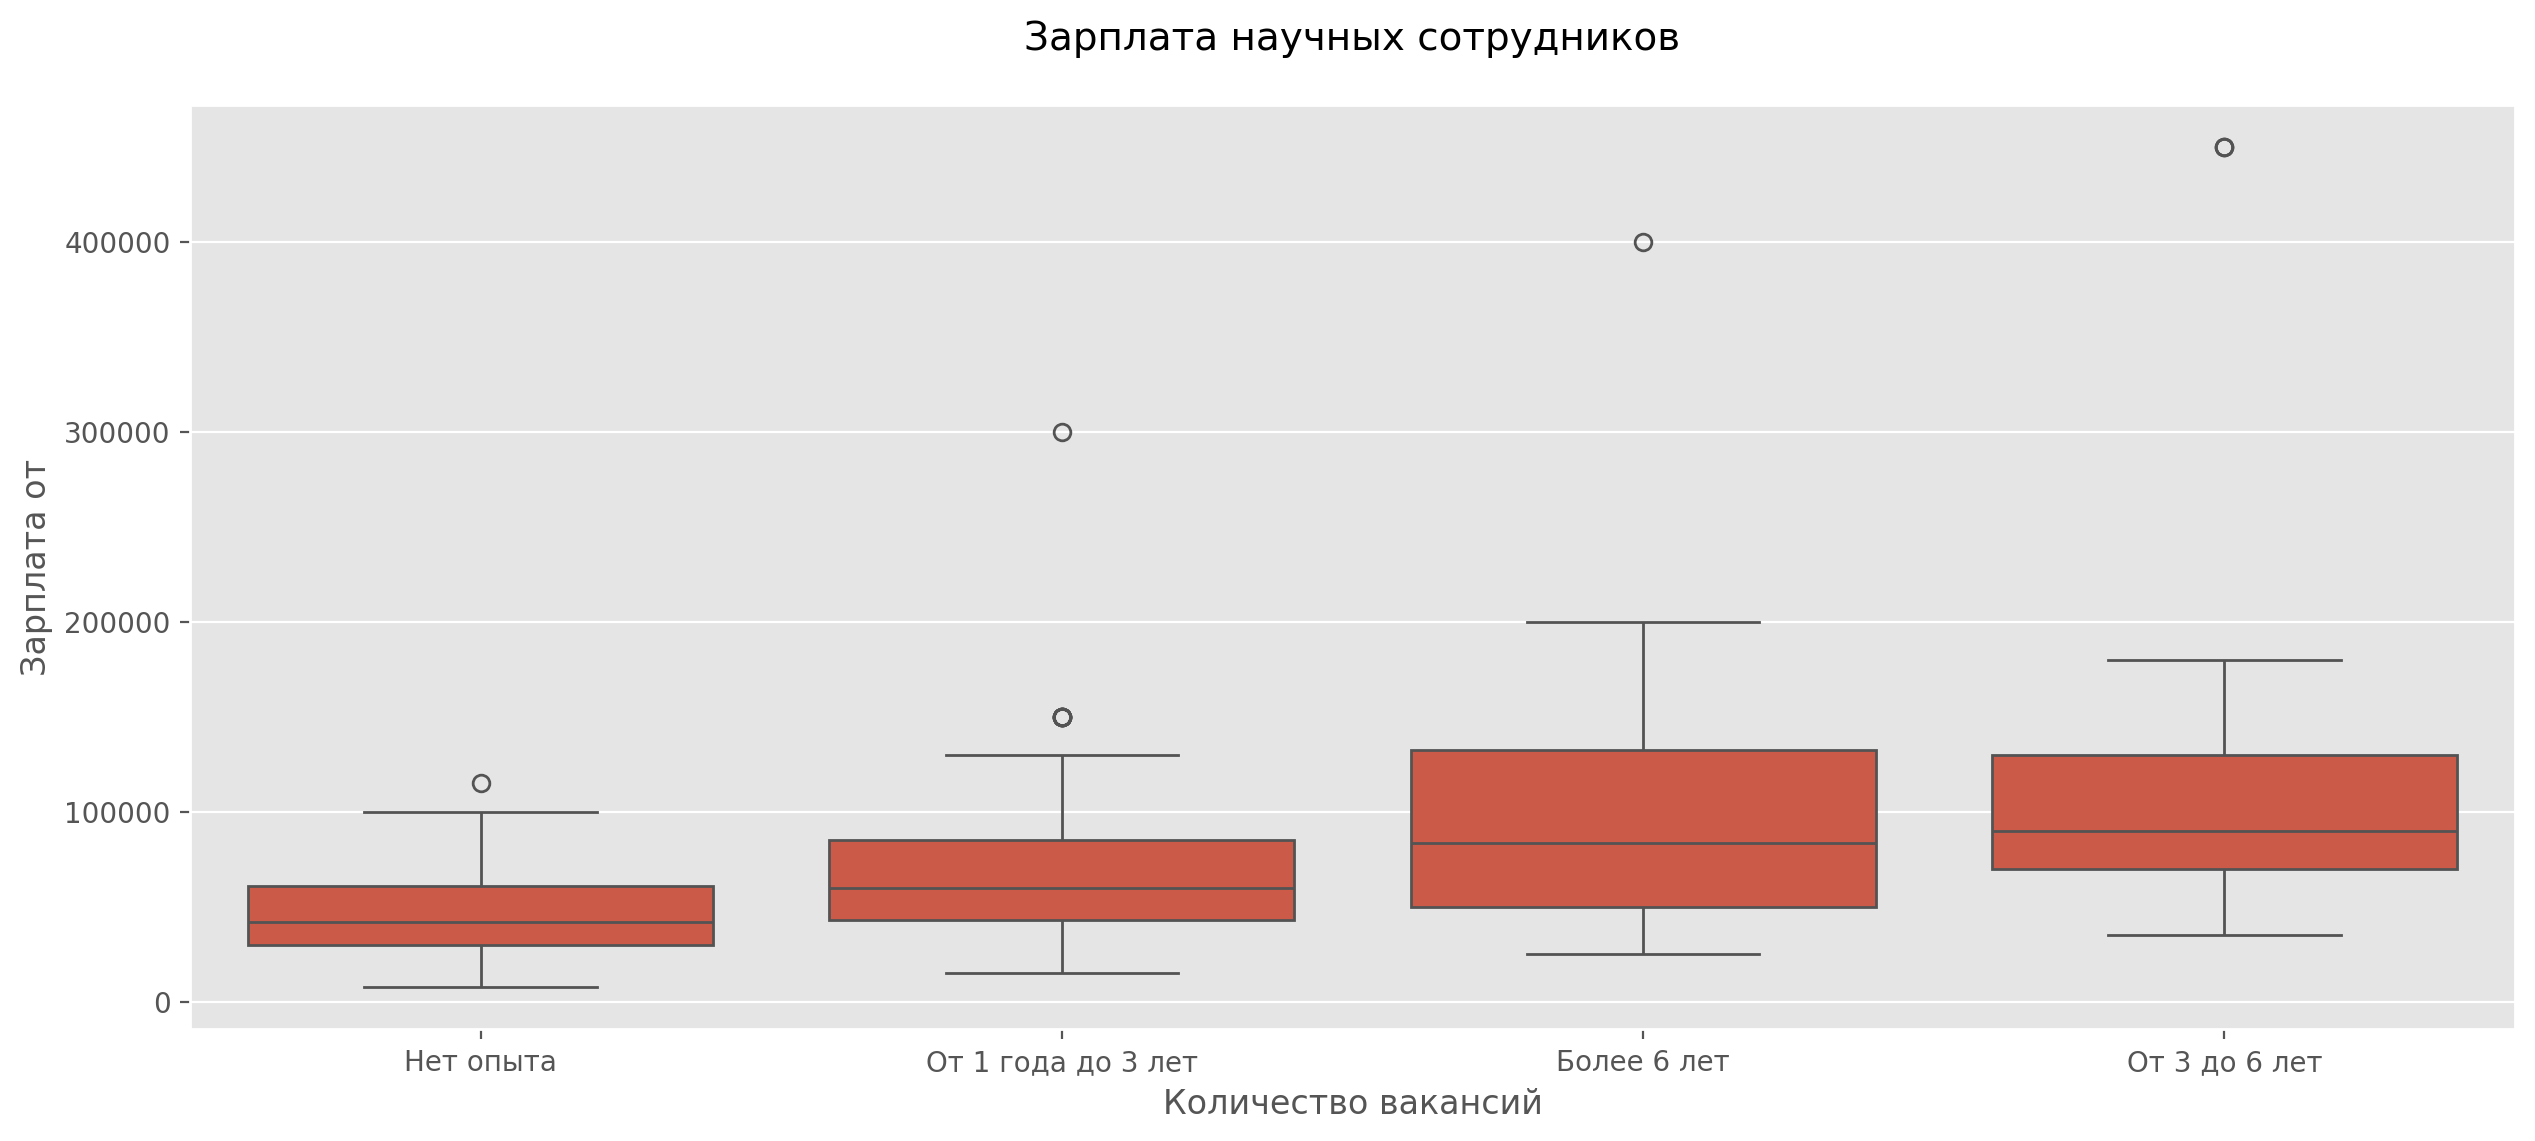

In [ ]:
# Строим график c сортировкой
median_salary_res = df_hh_researches.groupby('experience')['salary_from'].median()
sorted_categories_res = median_salary_res.sort_values().index

sns.boxplot(x='experience', y='salary_from', data=df_hh_researches, order=sorted_categories_res)

plt.title('Зарплата научных сотрудников', fontsize=14, pad=20)
plt.xlabel('Количество вакансий')
plt.ylabel('Зарплата от')
plt.show()

- Из графика видно, что все медианные зарплаты лежат в пределах 100 тыс. рублей.
- С ростом опыта зарплата растет, но при опыте от 3 до 6 лет и более 6 лет разницы в зарплатах нет.
- Есть большая неоднородность в уровне зарплат, на что указывает большое стандартное отклонение.

Посмотрим на количество вакансий с зарплатой выше 150 тыс. рублей

In [ ]:
# выводим вакансии с уровнем выше 150 тыс.руб.
len(df_hh_researches[df_hh_researches['salary_from'] > 150000])

22

Их всего 22.

## Сравнение зарплат

Сравним зарплаты аналитиков данных и научных сотрудников.

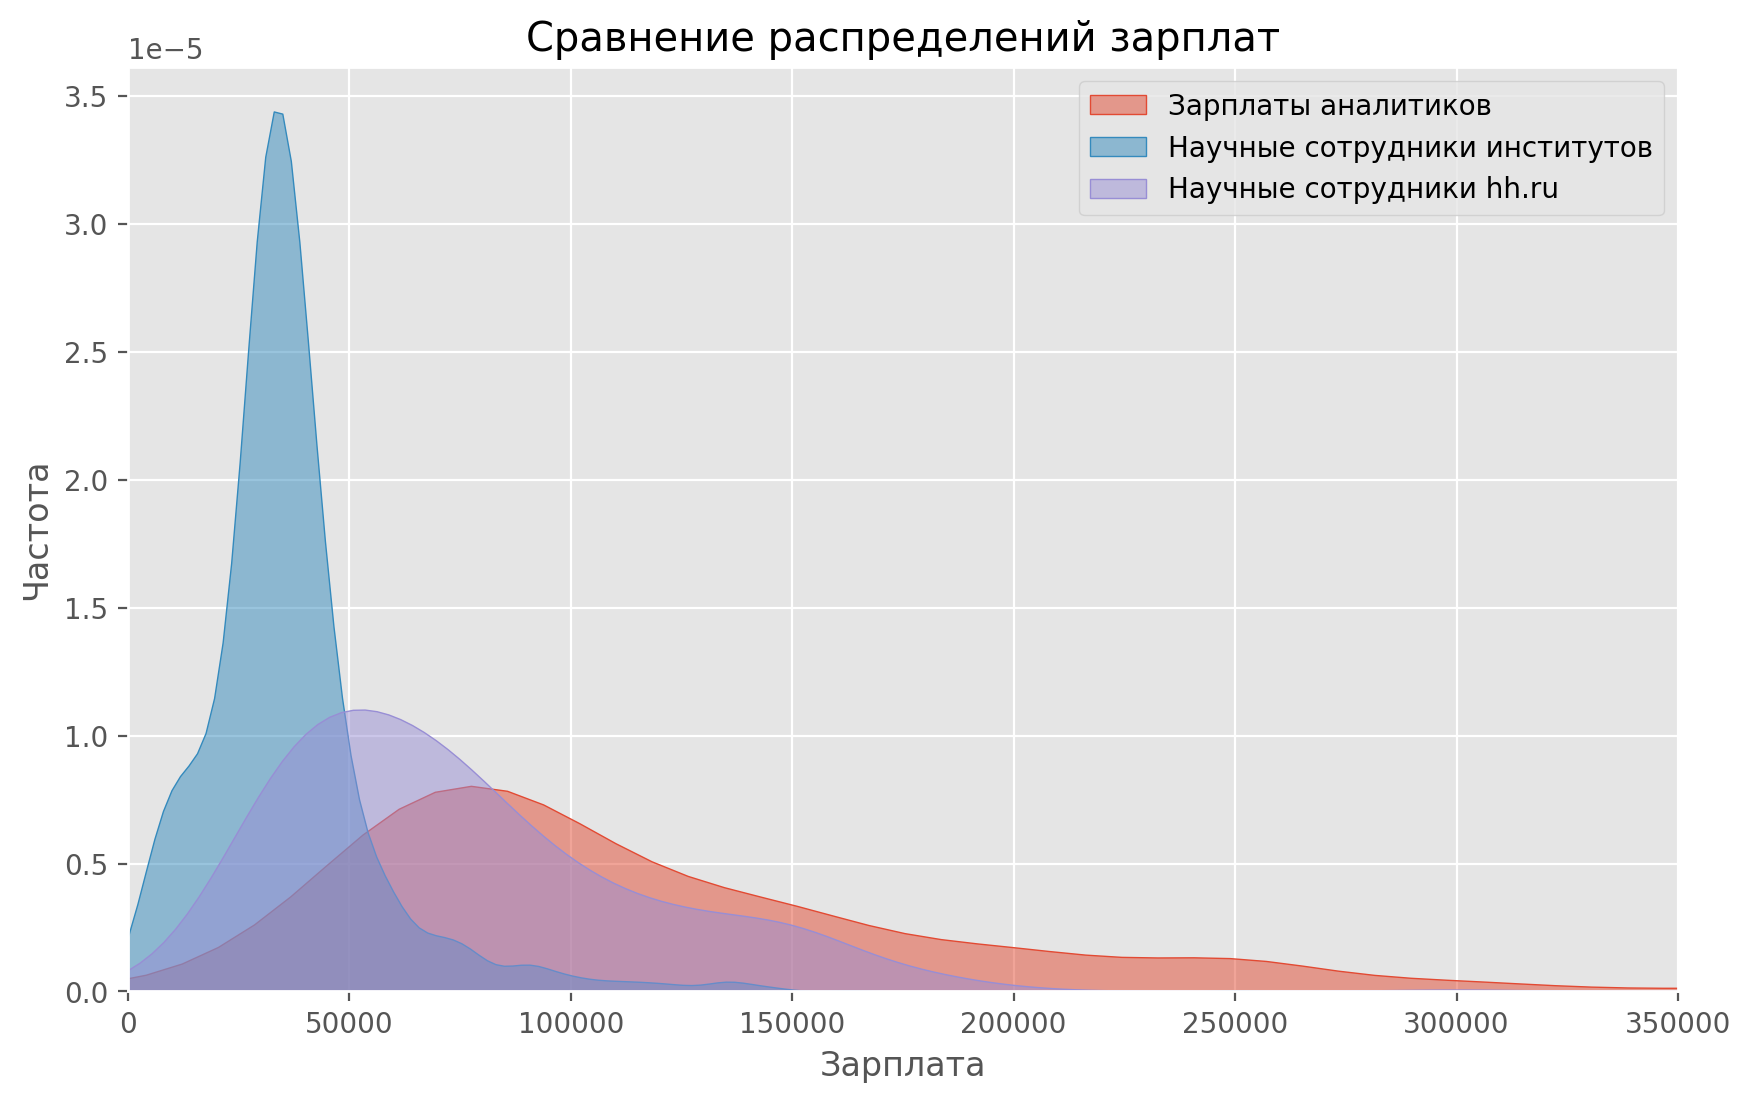

In [ ]:
# выведем распределеине зарплат всех трех категорий

plt.figure(figsize=(10, 6))
sns.kdeplot(da['salary_from'], alpha=0.5, label='Зарплаты аналитиков', fill=True)
sns.kdeplot(df['salary_from'], alpha=0.5, label='Научные сотрудники институтов', fill=True)
sns.kdeplot(df_hh_researches['salary_from'], alpha=0.5, label='Научные сотрудники hh.ru', fill=True)
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.title('Сравнение распределений зарплат')
plt.xlim(0, 350000)
plt.legend()
plt.show()

Как можно видеть, распределение зарплат у аналитиков данных смещено в большую сторону в отличие от зарплат научных сотрудников.

# Вывод:
1. Официальные оклады научных сотрудников в научных организациях находятся в диапазоне от 27 до 40 тыс. рублей.
2. У научных сотрудников, чьи вакансии выставлены на hh.ru, диапозон зарплат выше и составляет от 40 до 150 тыс. рублей. Всего за полгода представлено 22 вакансии с указанной зарплатов выше 150 тыс. рублей.
3. Диапазон зарплат аналитиков данных сильно зависит от опыта. Общий диапазон равен примерно от 40 до 300 тыс. рублей. Количество вакансий за год наблюдения - более 9 тыс.
